In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import json
import time
import itertools
from scipy import stats
import psycopg2 as psql
from psycopg2.extras import RealDictCursor

import seaborn as sns
sns.set(color_codes=True)

/home/victor/.local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [1]:
def create_bounding_box(f):
    fuz = list(zip(*f))

    return [np.nanmin(fuz[0]), np.nanmax(fuz[0]), np.nanmin(fuz[1]), np.nanmax(fuz[1])]


def find_box_overlap(b1, b2):
    if (b1[0] <= b2[1]) & (b1[1] <= b2[0]) or (b1[2] <= b2[3]) & (b1[3] <= b2[2]):
        return None

    else:
        return [max([b1[0], b2[0]]), min([b1[1], b2[1]]), max([b1[2], b2[2]]), min([b1[3], b2[3]])]


def resample_flight(box, f):
    """Flights should be zipped list like zip(lat,lon)"""

    f_res = [(lat, lon, ts) for lat, lon, ts in f if (box[0] <= lat <= box[1]) & (box[2] <= lon <= box[3])]

    return f_res


def calc_coord_dst_simple(c1, c2):
    R = 6371.1 * 1000  # Radius of the Earth in m

    lon1 = c1[0]
    lat1 = c1[1]
    lon2 = c2[0]
    lat2 = c2[1]

    [lon1, lat1, lon2, lat2] = [math.radians(l) for l in [lon1, lat1, lon2, lat2]]

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    x = dlon * math.cos(dlat / 2)
    y = dlat
    d = math.sqrt(x * x + y * y) * R

    return d


def calc_coord_dst(c1, c2):
    R = 6371.1 * 1000  # Radius of the Earth in m

    lat1 = c1[0]
    lon1 = c1[1]
    lat2 = c2[0]
    lon2 = c2[1]

    [lon1, lat1, lon2, lat2] = [math.radians(l) for l in [lon1, lat1, lon2, lat2]]

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    d = R * c
    return d


def calc_bearing(c0, c1):
    if not all(isinstance(i, tuple) for i in [c0, c1]):
        return np.nan

    lat1 = c0[0]
    lon1 = c0[1]
    lat2 = c1[0]
    lon2 = c1[1]

    [lon1, lat1, lon2, lat2] = [math.radians(l) for l in [lon1, lat1, lon2, lat2]]

    dlon = lon2 - lon1

    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dlon)
    y = math.sin(dlon) * math.cos(lat2)
    bearing = math.atan2(y, x)

    return math.degrees(bearing)


def box_area(box):
    w = calc_coord_dst_simple([box[0], box[2]], [box[1], box[2]])
    h = calc_coord_dst_simple([box[0], box[2]], [box[0], box[3]])

    return w * h


def closest_distance(f1, f2):
    """Flights should be zipped list like zip(lat,lon)"""

    x = [[np.sqrt((c1[0] - c2[0]) ** 2 + (c1[1] - c2[1]) ** 2) for c1 in f1] for c2 in f2]
    dmin = np.nanmin(x)
    if2, if1 = np.where(x == dmin)

    c2 = f2[if2[0]]
    c1 = f1[if1[0]]
    dmin_m = calc_coord_dst(c1, c2)

    return dmin_m, c1, c2, if1[0], if2[0]


def dst_aligned_times(f1, f2):
    """Flights should be zipped list like zip(lat,lon,ts)"""

    t = [[abs(c1[2] - c2[2]) for c1 in f1] for c2 in f2]
    tmin = np.nanmin(t)
    if2, if1 = np.where(t == tmin)


def find_flight_intersect(f1, f2):
    cnd = True
    first_it = True
    ba_old = None
    area_cnd = 0.95

    while cnd:
        f1_box = create_bounding_box(f1)
        f2_box = create_bounding_box(f2)

        obox = find_box_overlap(f1_box, f2_box)

        if obox:

            if not first_it:
                ba_old = ba
                ba = box_area(obox)
            else:
                ba = box_area(obox)

            if ba_old:
                if ba / ba_old > area_cnd:
                    return f1, f2

                else:

                    f1 = resample_flight(obox, f1)
                    f2 = resample_flight(obox, f2)
            else:

                f1 = resample_flight(obox, f1)
                f2 = resample_flight(obox, f2)

        else:
            return None, None

        if len(f1) == 0 or len(f2) == 0:
            return None, None

        first_it = False

        if len(f1) < 20:
            cnd = False

        # else:
        #     return None, None

    return f1, f2

In [4]:
try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)

fl_start_ep = 1512225284
fetch_batch_size = 500
ts_offset = 3600
max_dst = 5 * 1852
max_ts = 30
alt_min = 15000

cur_read = conn.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT ts, lat, lon, alt, spd, hdg, roc, start_ep, flight_id \
                 FROM public.adsb_flights WHERE flight_length > 500 \
                 AND start_ep BETWEEN %s AND %s;",
                (fl_start_ep - ts_offset, fl_start_ep + ts_offset))

f_list = []
fsets = []
sql_inj_lst = []
col_lst = ['td','altd','dstd','hdgd',
           'flight_id_1','ts_1','lat_1','lon_1','alt_1','spd_1','hdg_1','roc_1',
           'flight_id_2','ts_2','lat_2','lon_2','alt_2','spd_2','hdg_2','roc_2']

batch = cur_read.fetchall()

id_lst = [b['flight_id'] for b in batch]
fset = list(itertools.combinations(id_lst,2))

cnt = 1
print(len(fset))
    
for fs in fset:
    
    if (not cnt % 1000):
        print(cnt)
    
    f1 = next(f for f in batch if f['flight_id']==fs[0])
    f2 = next(f for f in batch if f['flight_id']==fs[1])

    if abs(f1['start_ep']-f2['start_ep']) < 1800:
        # f1 = {k: v for k, v in f1.items() if }
        f1crd = [(lt, ln, ts) for lt, ln, alt, ts in 
                 list(zip(f1['lat'], f1['lon'], f1['alt'], f1['ts'])) if alt > alt_min]

        f2crd = [(lt, ln, ts) for lt, ln, alt, ts in 
                 list(zip(f2['lat'], f2['lon'], f2['alt'], f2['ts'])) if alt > alt_min]

        if len(f2crd) > 20 and len(f1crd) > 20:

            t1 = time.time()

            fi1, fi2 = find_flight_intersect(f1crd, f2crd)

            if fi1 and fi2:
                d, c1, c2, i1, i2 = closest_distance(list(fi1), list(fi2))
                bdiff = abs(calc_bearing((fi1[i1-1][0], fi1[i1-1][1]),(fi1[i1][0], fi1[i1][1])) - 
                            calc_bearing((fi2[i2-1][0], fi2[i2-1][1]),(fi2[i2][0], fi2[i2][1])))
                tdiff = abs(fi1[i1][2] - fi2[i2][2])

                if d < max_dst and bdiff > 10: #and tdiff < max_ts
                    
                    print(bdiff)

                    print((d, c1, c2))
                    print(tdiff)
                    print("start_ep_diff: %f" % (abs(f1['start_ep']-f2['start_ep'])))
                    print("Calc took: %f seconds" % (time.time()-t1))

                    f1ix = f1['ts'].index(fi1[i1][2])
                    f2ix = f2['ts'].index(fi2[i2][2])
                    
                    confl = {}
                    for k in ['ts','lat','lon','alt','spd','hdg','roc']:
                        confl[('%s_1' % k)] = f1[k][:f1ix]
                    for k in ['ts','lat','lon','alt','spd','hdg','roc']:
                        confl[('%s_2' % k)] = f2[k][:f2ix]
                    confl['flight_id_1'] = f1['flight_id']
                    confl['flight_id_2'] = f2['flight_id']
                    confl['td'] = abs(f1['ts'][f1ix] - f2['ts'][f2ix])
                    confl['altd'] = abs(f1['alt'][f1ix] - f2['alt'][f2ix])
                    confl['dstd'] = d
                    confl['hdgd'] = abs(f1['hdg'][f1ix] - f2['hdg'][f2ix])
                        
                    sql_inj_lst.append(tuple(confl[kk] for kk in col_lst))
                    
    cnt = cnt + 1
    
    if len(sql_inj_lst) > 100:

        cur_inj = conn.cursor()
        records_list_template = ','.join(['%s'] * len(sql_inj_lst))
        insert_query = 'insert into conflicts (td, altd, dstd, hdgd,\
                                                flight_id_1, ts_1, lat_1, lon_1, alt_1, spd_1, hdg_1, roc_1,\
                                                flight_id_2, ts_2, lat_2, lon_2, alt_2, spd_2, hdg_2, roc_2) \
                                                values {}'.format(records_list_template)
        cur_inj.execute(insert_query, sql_inj_lst)
        conn.commit()
        cur_inj.close()
        sql_inj_lst = []

cur_read.close()

cur_inj = conn.cursor()
records_list_template = ','.join(['%s'] * len(sql_inj_lst))
insert_query = 'insert into conflicts (td, altd, dstd, hdgd,\
                                        flight_id_1, ts_1, lat_1, lon_1, alt_1, spd_1, hdg_1, roc_1,\
                                        flight_id_2, ts_2, lat_2, lon_2, alt_2, spd_2, hdg_2, roc_2) \
                                        values {}'.format(records_list_template)
cur_inj.execute(insert_query, sql_inj_lst)
conn.commit()
cur_inj.close()
sql_inj_lst = []


68265
35.62672259028163
(119.2685241256705, (51.61954, 2.16809, 1512227825.44), (51.62061, 2.16797, 1512226759.68))
1065.7599999904633
start_ep_diff: 1314.790000
Calc took: 0.050903 seconds
15.299075816177734
(47.99135701355872, (51.61698, 2.14684, 1512227831.55), (51.61656, 2.14668, 1512225860.5))
1971.0499999523163
start_ep_diff: 1177.610000
Calc took: 0.022671 seconds
29.909468319867457
(735.8288508526598, (51.62611, 2.22359, 1512227809.55), (51.61972, 2.22636, 1512230054.76))
2245.210000038147
start_ep_diff: 1651.870000
Calc took: 0.003211 seconds
186.4204776066257
(442.8784259797664, (51.91101, 3.12804, 1512227516.92), (51.9147, 3.12561, 1512226277.24))
1239.6800000667572
start_ep_diff: 1507.580000
Calc took: 0.003526 seconds
158.99224274059014
(5794.18704930293, (51.9147, 3.13972, 1512227513.05), (51.96673, 3.13511, 1512225477.82))
2035.2300000190735
start_ep_diff: 1228.860000
Calc took: 0.001586 seconds
78.58362274761501
(380.9246289502549, (51.49667, 0.58398, 1512228286.84), (5

10.216569170399694
(256.0569441990061, (51.68806, 1.1405, 1512224027.0), (51.69012, 1.13884, 1512225884.18))
1857.1800000667572
start_ep_diff: 1288.970000
Calc took: 0.004000 seconds
224.14579757352814
(351.1153682281476, (50.56929, 5.87096, 1512222462.79), (50.56618, 5.8701, 1512223589.13))
1126.340000152588
start_ep_diff: 739.170000
Calc took: 0.002109 seconds
170.0242960805058
(110.05022973926616, (50.68002, 5.5014, 1512222585.29), (50.67905, 5.50171, 1512225113.94))
2528.6500000953674
start_ep_diff: 1402.230000
Calc took: 0.013061 seconds
89.49893232317436
(153.3375209346367, (51.07425, 4.13954, 1512223034.75), (51.07288, 4.13979, 1512224128.37))
1093.619999885559
start_ep_diff: 1061.510000
Calc took: 0.003784 seconds
73.45911648094183
(191.68576350027382, (51.07511, 4.13628, 1512223035.7), (51.0767, 4.13734, 1512222703.78))
331.92000007629395
start_ep_diff: 35.550000
Calc took: 0.003170 seconds
87.53490134160299
(141.87843067226143, (51.08221, 4.11126, 1512223043.77), (51.08098, 4

142.40376868450886
(195.65132799370042, (49.57306, 4.80444, 1512228308.72), (49.57283, 4.80175, 1512227130.84))
1177.880000114441
start_ep_diff: 1192.860000
Calc took: 0.001902 seconds
81.85143695091743
(539.8902865421184, (49.79604, 6.28938, 1512227894.59), (49.79214, 6.2849, 1512228309.27))
414.6800000667572
start_ep_diff: 107.430000
Calc took: 0.001364 seconds
26.566882362414447
(53.361294499201186, (49.38638, 3.3278, 1512228789.46), (49.38684, 3.32801, 1512229916.81))
1127.3499999046326
start_ep_diff: 688.650000
Calc took: 0.002629 seconds
39.8422085783765
(36.24677879949719, (49.45143, 3.724, 1512228626.65), (49.45165, 3.72437, 1512227085.58))
1541.0700001716614
start_ep_diff: 1187.170000
Calc took: 0.001927 seconds
12.261370882756395
(2765.5136001807277, (49.43829, 3.61124, 1512228670.33), (49.46315, 3.61235, 1512228532.68))
137.64999985694885
start_ep_diff: 408.070000
Calc took: 0.003350 seconds
113.89790504102952
(3586.6302651511965, (49.8517, 6.73079, 1512227771.41), (49.85274

114.64172914777068
(638.2406730101966, (49.17998, 2.78834, 1512226549.36), (49.18414, 2.78229, 1512227307.79))
758.4300000667572
start_ep_diff: 4.610000
Calc took: 0.002049 seconds
107.02525415567224
(738.694985660499, (49.39188, 2.57728, 1512226690.13), (49.38547, 2.5746, 1512226594.19))
95.94000005722046
start_ep_diff: 703.940000
Calc took: 0.002927 seconds
64.10714665618906
(578.1513886956469, (49.69549, 2.29985, 1512226889.59), (49.69051, 2.30216, 1512226659.72))
229.86999988555908
start_ep_diff: 233.660000
Calc took: 0.028100 seconds
111.19959606534337
(1664.229188263638, (49.07332, 3.03338, 1512226449.01), (49.0584, 3.03518, 1512225986.29))
462.72000002861023
start_ep_diff: 363.350000
Calc took: 0.004019 seconds
103.95196352481486
(480.44682759815976, (49.47523, 2.50134, 1512226744.92), (49.47093, 2.50069, 1512226387.43))
357.49000000953674
start_ep_diff: 796.950000
Calc took: 0.004235 seconds
114.07073719573484
(469.94881989540505, (49.10009, 2.97158, 1512226473.99), (49.10426, 

86.61924722091369
(141.53793208366454, (50.21832, 8.04875, 1512228848.77), (50.21934, 8.04994, 1512229863.56))
1014.789999961853
start_ep_diff: 1133.240000
Calc took: 0.003646 seconds
139.39628834042531
(6241.046051106139, (50.38559, 8.61465, 1512229059.07), (50.34192, 8.66992, 1512227677.08))
1381.9900000095367
start_ep_diff: 250.110000
Calc took: 0.001834 seconds
138.99641196981258
(7960.38245373959, (50.46858, 8.9003, 1512229164.13), (50.5392, 8.91875, 1512230658.92))
1494.789999961853
start_ep_diff: 228.440000
Calc took: 0.003895 seconds
42.33121851239301
(775.8832136783526, (49.90453, 7.02164, 1512228459.08), (49.91131, 7.0242, 1512229335.75))
876.670000076294
start_ep_diff: 1005.300000
Calc took: 0.003848 seconds
53.089043374405215
(1046.2374918821668, (49.74559, 6.51706, 1512228264.72), (49.73725, 6.5238, 1512228600.9))
336.1800000667572
start_ep_diff: 878.800000
Calc took: 0.010216 seconds
45.13451370880006
(1082.9441178870425, (50.55556, 9.20401, 1512229274.91), (50.54654, 9.1

12.898932280139789
(66.90259034478156, (50.35451, 5.64625, 1512226101.35), (50.35391, 5.64632, 1512227265.22))
1163.8700001239777
start_ep_diff: 1168.460000
Calc took: 0.165935 seconds
110.15532002421982
(415.2502881468293, (50.48163, 5.91093, 1512226237.8), (50.48264, 5.91658, 1512223629.88))
2607.9199998378754
start_ep_diff: 1581.100000
Calc took: 0.002415 seconds
63.62389850210709
(1799.3756175728752, (50.39227, 5.72453, 1512226141.35), (50.37616, 5.72214, 1512226413.94))
272.5900001525879
start_ep_diff: 370.010000
Calc took: 0.004588 seconds
64.68461637393375
(2580.7761336269973, (50.1454, 5.21518, 1512225896.24), (50.16832, 5.22088, 1512225071.81))
824.4300000667572
start_ep_diff: 1473.850000
Calc took: 0.007176 seconds
70.73518233417451
(480.3078567881639, (49.46928, 3.86871, 1512225261.41), (49.47358, 3.86808, 1512226788.5))
1527.0899999141693
start_ep_diff: 648.960000
Calc took: 0.044641 seconds
51.207466896466116
(69.9995467942606, (50.58417, 6.12726, 1512226348.99), (50.58357

70.5280847139087
(776.2656323557746, (50.68435, 3.34541, 1512226173.9), (50.67764, 3.34237, 1512226562.21))
388.30999994277954
start_ep_diff: 167.840000
Calc took: 0.005153 seconds
79.76364750282602
(423.3084531036886, (50.66464, 3.4088, 1512226196.11), (50.66844, 3.40916, 1512224927.29))
1268.8199999332428
start_ep_diff: 1610.770000
Calc took: 0.005029 seconds
115.07067664874681
(138.96972377971161, (50.78, 3.03297, 1512226066.14), (50.78044, 3.03482, 1512226089.69))
23.549999952316284
start_ep_diff: 618.680000
Calc took: 0.005885 seconds
249.10520087369417
(163.27173403973453, (50.32418, 4.48495, 1512226571.65), (50.32534, 4.48636, 1512228605.65))
2034.0
start_ep_diff: 1427.880000
Calc took: 0.006384 seconds
274.4710242856087
(212.49483111607722, (50.54703, 3.78627, 1512226329.23), (50.54517, 3.78696, 1512226654.32))
325.0899999141693
start_ep_diff: 543.950000
Calc took: 0.002713 seconds
59.50320288213204
(284.1490798864769, (50.62276, 3.54374, 1512226243.53), (50.62454, 3.54663, 151

114.35290093522764
(45.018448313737544, (51.31329, 4.06591, 1512224660.73), (51.31369, 4.06601, 1512226600.96))
1940.2300000190735
start_ep_diff: 854.520000
Calc took: 0.003451 seconds
62.011129401074484
(222.81527476146485, (51.26765, 4.88411, 1512224413.7), (51.26843, 4.88706, 1512224198.77))
214.9300000667572
start_ep_diff: 1158.340000
Calc took: 0.002587 seconds
23.15650417192849
(139.59195200756434, (51.67099, 2.05311, 1512225358.95), (51.67201, 2.05429, 1512227456.17))
2097.2200000286102
start_ep_diff: 1280.190000
Calc took: 0.003903 seconds
244.42354166929027
(393.9201365135039, (51.25191, 5.14583, 1512224334.75), (51.24941, 5.14984, 1512224915.86))
581.1099998950958
start_ep_diff: 534.050000
Calc took: 0.002095 seconds
40.23188734997217
(294.3039147733166, (51.57541, 2.58766, 1512225163.48), (51.57788, 2.58919, 1512223826.74))
1336.7400000095367
start_ep_diff: 840.130000
Calc took: 0.003526 seconds
100.66360693655058
(603.1129780209819, (50.57158, 6.19, 1512227875.34), (50.5761

280.3095794430949
(1995.5602271995222, (50.56618, 6.20142, 1512227508.44), (50.55121, 6.217, 1512228315.99))
807.5499999523163
start_ep_diff: 529.030000
Calc took: 0.191591 seconds
174.43767424394076
(73.39932878162546, (51.48926, 5.32399, 1512226991.58), (51.48898, 5.32495, 1512227461.85))
470.2699999809265
start_ep_diff: 465.830000
Calc took: 0.010567 seconds
95.88566087477693
(730.6696121973969, (50.84636, 5.75493, 1512227316.37), (50.84052, 5.75016, 1512227048.9))
267.46999979019165
start_ep_diff: 1380.100000
Calc took: 0.018387 seconds
293.4216204674379
(388.4142696513046, (51.02907, 5.51666, 1512227205.67), (51.02586, 5.51885, 1512227205.83))
0.15999984741210938
start_ep_diff: 574.690000
Calc took: 0.004763 seconds
258.59200301521173
(816.4605963944781, (50.60628, 6.13738, 1512227480.72), (50.5993, 6.13379, 1512226152.88))
1327.8399999141693
start_ep_diff: 1736.980000
Calc took: 0.004531 seconds
32.56826560859224
(597.6405651643726, (50.35464, 6.53484, 1512227653.13), (50.35153, 

15.412198519906923
(98.4054794568426, (51.43831, 3.09395, 1512225513.22), (51.43744, 3.09421, 1512226020.39))
507.17000007629395
start_ep_diff: 31.320000
Calc took: 0.145082 seconds
15.494908311807222
(161.5485571728899, (51.74849, 1.60408, 1512226052.76), (51.74721, 1.60519, 1512226766.07))
713.3099999427795
start_ep_diff: 615.870000
Calc took: 0.004035 seconds
66.0734030781971
(275.93126293873024, (50.66741, 5.67214, 1512224648.18), (50.66917, 5.66938, 1512226059.66))
1411.4800000190735
start_ep_diff: 1682.340000
Calc took: 0.003859 seconds
230.15530512275743
(358.8094344426886, (50.67509, 5.64568, 1512224656.97), (50.6776, 5.64888, 1512225408.03))
751.0599999427795
start_ep_diff: 220.540000
Calc took: 0.003246 seconds
73.50667524531141
(245.3261228613315, (50.45746, 6.38573, 1512224408.75), (50.45955, 6.38462, 1512226511.23))
2102.4800000190735
start_ep_diff: 1222.860000
Calc took: 0.004386 seconds
11.201985352985943
(158.15289556877937, (51.73192, 1.75156, 1512225998.22), (51.7305,

77.30273394520607
(332.1594233407524, (51.00545, 3.36078, 1512224399.77), (51.00833, 3.35952, 1512223537.68))
862.0899999141693
start_ep_diff: 648.320000
Calc took: 0.005044 seconds
97.16272525913503
(38.5344631874328, (51.32053, 3.62467, 1512224611.7), (51.32077, 3.62427, 1512225845.4))
1233.7000000476837
start_ep_diff: 1011.640000
Calc took: 0.003362 seconds
76.62762194648127
(1009.6128910310774, (49.74777, 2.15904, 1512223519.1), (49.75465, 2.16821, 1512225457.99))
1938.8900001049042
start_ep_diff: 1320.500000
Calc took: 0.004337 seconds
96.274372089538
(1141.8418133853493, (50.97166, 3.3322, 1512224376.92), (50.98192, 3.33153, 1512223868.62))
508.30000019073486
start_ep_diff: 205.610000
Calc took: 0.002380 seconds
69.22455985896626
(2521.249422712593, (49.81923, 2.22785, 1512223567.79), (49.83806, 2.24743, 1512224465.71))
897.920000076294
start_ep_diff: 407.820000
Calc took: 0.003855 seconds
80.44326473027351
(4506.984848396429, (49.95995, 2.36562, 1512223667.17), (49.92151, 2.3456

53.63732836447654
(253.63181438363395, (51.71773, 2.82831, 1512230232.96), (51.72, 2.82867, 1512227349.34))
2883.6200001239777
start_ep_diff: 1772.020000
Calc took: 0.134457 seconds
82.96948285885037
(27.87793213574637, (51.33446, 3.53386, 1512229930.87), (51.33444, 3.53426, 1512230422.56))
491.69000005722046
start_ep_diff: 231.930000
Calc took: 0.006250 seconds
82.88824629495524
(61.40368748817461, (50.93639, 4.64157, 1512229519.95), (50.93592, 4.64111, 1512230655.57))
1135.619999885559
start_ep_diff: 419.120000
Calc took: 0.005812 seconds
94.45890839744985
(36.99573998962192, (51.09416, 4.15662, 1512229694.09), (51.09425, 4.15611, 1512229461.73))
232.35999989509583
start_ep_diff: 913.210000
Calc took: 0.004144 seconds
79.52351423983423
(284.8648855932292, (51.34442, 3.5154, 1512229938.83), (51.34227, 3.51763, 1512229026.83))
912.0
start_ep_diff: 1207.200000
Calc took: 0.005126 seconds
260.9547058282714
(153.67906922813341, (51.10547, 4.12165, 1512229706.67), (51.10684, 4.12136, 15122

125.84663235723059
(930.6528239076973, (49.54065, 4.27404, 1512229074.52), (49.54857, 4.27821, 1512230623.38))
1548.8600001335144
start_ep_diff: 1677.390000
Calc took: 0.002613 seconds
276.6200529816006
(891.4229316538613, (51.32071, 7.05886, 1512227906.68), (51.31453, 7.06703, 1512228142.26))
235.57999992370605
start_ep_diff: 91.910000
Calc took: 0.004924 seconds
245.61299177624818
(364.30026791207547, (50.41165, 6.06802, 1512228389.81), (50.40872, 6.07032, 1512226030.24))
2359.569999933243
start_ep_diff: 1711.450000
Calc took: 0.002611 seconds
214.7236137221578
(841.0165583163171, (52.37895, 8.27577, 1512227338.59), (52.37302, 8.28346, 1512226654.06))
684.5299999713898
start_ep_diff: 1685.150000
Calc took: 0.002050 seconds
29.106001924332574
(872.2543241121286, (49.65225, 5.07005, 1512228837.71), (49.66008, 5.06932, 1512226918.69))
1919.0199999809265
start_ep_diff: 1376.040000
Calc took: 0.003886 seconds
285.02750773073205
(8213.806457840814, (50.72617, 6.40547, 1512228223.69), (50.6

15.350741158241213
(1189.0410506990252, (50.3568, 3.21018, 1512224549.81), (50.36728, 3.20685, 1512225109.1))
559.289999961853
start_ep_diff: 284.500000
Calc took: 0.006863 seconds
78.51412873417945
(644.7361067481063, (50.63855, 3.56157, 1512224772.13), (50.64432, 3.56247, 1512224465.34))
306.7900002002716
start_ep_diff: 738.660000
Calc took: 0.002554 seconds
173.65340019612472
(131.8521639912782, (50.23421, 3.05131, 1512224454.03), (50.23535, 3.0508, 1512225838.56))
1384.5299999713898
start_ep_diff: 1308.520000
Calc took: 0.005741 seconds
73.41750233180854
(376.026530463544, (50.77527, 3.73436, 1512224882.83), (50.7782, 3.73169, 1512224890.52))
7.690000057220459
start_ep_diff: 457.390000
Calc took: 0.001395 seconds
261.9352509461323
(120.75663856033816, (50.80795, 3.9814, 1512223364.75), (50.80687, 3.98158, 1512224455.73))
1090.9800000190735
start_ep_diff: 792.360000
Calc took: 0.002390 seconds
266.43751303467974
(138.85781552388153, (50.88309, 4.02908, 1512223330.74), (50.8819, 4.02

58.07082703997493
(153.9834012991322, (50.49549, 5.73026, 1512225080.82), (50.49413, 5.73067, 1512225493.49))
412.67000007629395
start_ep_diff: 1016.520000
Calc took: 0.002260 seconds
69.57081926334732
(525.1171960553146, (50.57474, 5.30134, 1512224929.09), (50.571, 5.30588, 1512225619.95))
690.8600001335144
start_ep_diff: 749.620000
Calc took: 0.003261 seconds
79.3037315666813
(342.7459559271685, (50.799, 4.02775, 1512224472.36), (50.80208, 4.02794, 1512224001.89))
470.46999979019165
start_ep_diff: 12.050000
Calc took: 0.002737 seconds
214.910281245276
(19.921119196027302, (50.69499, 4.63007, 1512224688.91), (50.69487, 4.63028, 1512223561.76))
1127.1500000953674
start_ep_diff: 1321.780000
Calc took: 0.011511 seconds
251.61429940307124
(510.25041937803303, (50.73322, 4.41108, 1512224610.18), (50.73738, 4.41414, 1512226054.78))
1444.5999999046326
start_ep_diff: 989.280000
Calc took: 0.003474 seconds
269.8775151569295
(176.57958235896882, (50.86149, 3.65646, 1512224339.05), (50.86015, 3.

52.025414063560476
(901.5226813402305, (49.82314, 2.15228, 1512226863.79), (49.81578, 2.14701, 1512225427.68))
1436.1099998950958
start_ep_diff: 1326.750000
Calc took: 0.044089 seconds
121.04697726359434
(4501.256610549688, (49.02104, 2.83356, 1512226352.41), (48.98929, 2.87184, 1512229333.63))
2981.2200000286102
start_ep_diff: 719.810000
Calc took: 0.005381 seconds
126.89544651473366
(2548.386509043991, (49.06382, 2.79819, 1512226379.51), (49.08586, 2.80778, 1512229961.04))
3581.5299999713898
start_ep_diff: 1115.540000
Calc took: 0.002302 seconds
64.79354990568658
(638.9207972214072, (49.83394, 2.14278, 1512226870.56), (49.83797, 2.14913, 1512226833.66))
36.89999985694885
start_ep_diff: 233.470000
Calc took: 0.008162 seconds
141.67883687186313
(3749.6345648093447, (49.06382, 2.79819, 1512226379.51), (49.07899, 2.75222, 1512227354.34))
974.829999923706
start_ep_diff: 164.120000
Calc took: 0.001644 seconds
109.37393738423302
(3198.060340730823, (49.38224, 2.533, 1512226581.0), (49.35352

255.71278874306512
(18.66853099098058, (51.84839, 5.11162, 1512227263.56), (51.84825, 5.11177, 1512230085.7))
2822.140000104904
start_ep_diff: 1050.130000
Calc took: 0.002167 seconds
119.96461446016195
(202.160208038562, (50.52617, 5.87877, 1512227939.31), (50.52754, 5.87689, 1512227419.53))
519.7799999713898
start_ep_diff: 1584.560000
Calc took: 0.004143 seconds
49.52785013031405
(2611.175716737547, (50.02904, 6.15516, 1512228189.63), (50.04515, 6.12856, 1512227553.98))
635.6500000953674
start_ep_diff: 1267.170000
Calc took: 0.001919 seconds
259.3338778267753
(2236.4417271023003, (49.79214, 6.2849, 1512228309.27), (49.78124, 6.25872, 1512229366.33))
1057.0599999427795
start_ep_diff: 1420.450000
Calc took: 0.001378 seconds
131.9951709896791
(323.04161978989697, (50.53595, 5.87323, 1512227934.26), (50.53883, 5.87383, 1512227281.52))
652.7400000095367
start_ep_diff: 1666.540000
Calc took: 0.003587 seconds
305.6438495525641
(207.60913239761655, (51.55912, 5.28366, 1512227424.71), (51.5607

18.53526391656174
(118.608728639981, (51.25122, 3.16213, 1512230876.52), (51.25227, 3.16243, 1512228833.39))
2043.1299998760223
start_ep_diff: 1740.530000
Calc took: 0.012532 seconds
8000
169.14215290951364
(103.26479490054578, (50.50552, 6.82475, 1512229722.99), (50.50462, 6.82511, 1512229517.99))
205.0
start_ep_diff: 1688.740000
Calc took: 1.097507 seconds
61.90568436607434
(371.69328676531404, (50.832, 5.45575, 1512230166.03), (50.8293, 5.45887, 1512229968.25))
197.77999997138977
start_ep_diff: 485.300000
Calc took: 0.005327 seconds
234.6526880114522
(508.1123613282207, (50.78463, 5.66841, 1512230098.64), (50.78082, 5.66442, 1512228604.29))
1494.3500001430511
start_ep_diff: 1146.080000
Calc took: 0.003070 seconds
12.866176779917367
(83.75004433006464, (50.42825, 7.13439, 1512229622.51), (50.42876, 7.13352, 1512231051.68))
1429.170000076294
start_ep_diff: 25.290000
Calc took: 0.007259 seconds
39.34779838874452
(2710.4231620136293, (50.19566, 8.04091, 1512229324.81), (50.21934, 8.0499

68.39152813108625
(150.52627967325603, (50.28773, 4.90859, 1512226620.27), (50.28885, 4.90978, 1512225193.32))
1426.9500000476837
start_ep_diff: 1478.890000
Calc took: 0.005148 seconds
148.78626300813812
(2606.701300599521, (52.18641, 7.83074, 1512228135.71), (52.19293, 7.86747, 1512226540.88))
1594.829999923706
start_ep_diff: 763.220000
Calc took: 0.003347 seconds
81.08387801426991
(7540.531174053436, (49.05614, 2.90393, 1512225606.28), (48.99046, 2.92966, 1512225829.42))
223.14000010490417
start_ep_diff: 169.660000
Calc took: 0.002081 seconds
89.84154911553789
(1029.1802509598108, (51.54431, 6.81404, 1512227586.62), (51.55293, 6.81946, 1512225466.78))
2119.8399999141693
start_ep_diff: 722.130000
Calc took: 0.011114 seconds
117.29658895042806
(124.1750844506207, (51.35913, 6.52916, 1512227444.52), (51.36006, 6.52817, 1512224845.65))
2598.869999885559
start_ep_diff: 1312.780000
Calc took: 0.005263 seconds
111.45550388536174
(228.79891122599028, (52.05428, 7.61421, 1512228010.72), (52.0

77.36812583483642
(1664.324342353317, (50.61969, 4.9359, 1512227455.78), (50.63436, 4.94058, 1512228347.76))
891.9800000190735
start_ep_diff: 1084.720000
Calc took: 0.013536 seconds
243.74609561751078
(203.80634496523524, (50.61969, 4.9359, 1512227455.78), (50.62146, 4.93665, 1512227648.37))
192.5899999141693
start_ep_diff: 143.520000
Calc took: 0.004181 seconds
242.49876096836226
(1334.78804025856, (50.61969, 4.9359, 1512227455.78), (50.63166, 4.93732, 1512228463.43))
1007.6500000953674
start_ep_diff: 984.130000
Calc took: 0.005358 seconds
251.55667774322953
(140.09833851905324, (50.50539, 4.77435, 1512227526.17), (50.50615, 4.77593, 1512226395.94))
1130.2300000190735
start_ep_diff: 1109.960000
Calc took: 0.006764 seconds
292.8408828438526
(5377.908435975814, (48.68829, 2.57904, 1512228543.39), (48.72786, 2.5369, 1512226335.94))
2207.4500000476837
start_ep_diff: 861.470000
Calc took: 0.002113 seconds
77.2044049234669
(1105.5875120834114, (50.64445, 4.97095, 1512227440.57), (50.63452, 

92.09199725918941
(399.16412323018767, (50.48353, 4.7435, 1512227539.66), (50.4841, 4.73793, 1512225605.65))
1934.0099999904633
start_ep_diff: 1551.110000
Calc took: 0.695471 seconds
56.38850620404841
(180.90046053978202, (51.57838, 6.33599, 1512226864.23), (51.57676, 6.33575, 1512227514.44))
650.210000038147
start_ep_diff: 408.830000
Calc took: 0.004807 seconds
47.64475703279932
(932.8639943480633, (52.11484, 7.15637, 1512226527.97), (52.11337, 7.14292, 1512229785.9))
3257.930000066757
start_ep_diff: 1694.550000
Calc took: 0.002795 seconds
40.584487995076785
(1261.7821525008612, (52.85454, 8.45245, 1512226042.76), (52.84877, 8.46863, 1512229141.87))
3099.109999895096
start_ep_diff: 513.200000
Calc took: 0.013558 seconds
67.44661147484118
(2831.1029562064764, (52.11484, 7.15637, 1512226527.97), (52.14015, 7.16087, 1512227044.49))
516.5199999809265
start_ep_diff: 230.890000
Calc took: 0.003897 seconds
88.25093623750365
(1054.248932220658, (51.80165, 7.6474, 1512225635.3), (51.79408, 7.6

82.41039033121501
(348.72530774941595, (50.07289, 5.06113, 1512224325.4), (50.07052, 5.06433, 1512223995.63))
329.7699999809265
start_ep_diff: 456.360000
Calc took: 0.274802 seconds
79.0394587069429
(399.10930586018173, (50.03009, 5.00037, 1512224293.03), (50.02713, 5.00353, 1512223614.86))
678.170000076294
start_ep_diff: 932.340000
Calc took: 0.007331 seconds
110.56674710176185
(1319.6348041347724, (51.8057, 7.65381, 1512225638.4), (51.79445, 7.65992, 1512223523.64))
2114.7599999904633
start_ep_diff: 64.900000
Calc took: 0.002284 seconds
69.68767650381605
(2973.0449427076205, (51.7558, 7.57484, 1512225598.8), (51.78168, 7.58569, 1512223317.48))
2281.319999933243
start_ep_diff: 286.360000
Calc took: 0.003133 seconds
90.15900053612177
(980.7864041350982, (51.40681, 7.03184, 1512225327.4), (51.41524, 7.036, 1512223808.9))
1518.5
start_ep_diff: 69.210000
Calc took: 0.008294 seconds
94.80033879516262
(3131.234783885801, (51.7558, 7.57484, 1512225598.8), (51.78159, 7.59311, 1512224710.64))


240.6593975001649
(196.57429105347865, (50.18202, 5.18576, 1512226448.19), (50.18033, 5.18495, 1512228104.51))
1656.3199999332428
start_ep_diff: 1573.460000
Calc took: 0.009087 seconds
235.42791828518835
(101.31075137212396, (50.35785, 5.58142, 1512226325.41), (50.35876, 5.58149, 1512227253.7))
928.289999961853
start_ep_diff: 730.240000
Calc took: 0.006033 seconds
243.14432781329896
(803.0587507718042, (50.39713, 5.67058, 1512226297.53), (50.40408, 5.6675, 1512227292.04))
994.5099999904633
start_ep_diff: 804.180000
Calc took: 0.006540 seconds
91.65755135402716
(852.9121058643483, (51.49452, 7.85233, 1512225582.01), (51.49452, 7.84001, 1512224762.09))
819.920000076294
start_ep_diff: 896.240000
Calc took: 0.002523 seconds
252.2470798588658
(267.88984856538394, (49.65646, 3.98955, 1512226816.08), (49.65448, 3.99167, 1512227835.85))
1019.7699999809265
start_ep_diff: 1096.620000
Calc took: 0.004389 seconds
51.980036453427005
(1229.4329518508819, (51.34785, 7.55614, 1512225677.79), (51.3588,

63.751739724173724
(109.37296898590152, (50.09166, 5.85145, 1512225451.74), (50.0924, 5.85044, 1512226721.49))
1269.75
start_ep_diff: 414.200000
Calc took: 0.300187 seconds
162.4855917896544
(92.6900149704476, (50.72731, 4.30553, 1512225996.54), (50.72768, 4.30671, 1512227420.92))
1424.380000114441
start_ep_diff: 1297.410000
Calc took: 0.006793 seconds
105.92133583088585
(292.5597250685357, (50.89803, 3.8739, 1512226146.86), (50.90053, 3.8752, 1512227344.39))
1197.5300002098083
start_ep_diff: 929.530000
Calc took: 0.011483 seconds
171.48990972874628
(46.42787289422771, (50.43407, 5.03015, 1512225742.71), (50.43434, 5.03065, 1512226487.99))
745.2799999713898
start_ep_diff: 43.930000
Calc took: 0.018196 seconds
96.76882692283974
(111.2845653744984, (50.82895, 4.04922, 1512226085.6), (50.82992, 4.04961, 1512223988.98))
2096.619999885559
start_ep_diff: 1592.590000
Calc took: 0.005053 seconds
109.6663803157802
(699.9681172141602, (50.2605, 5.44974, 1512225593.88), (50.26673, 5.45115, 151222

14.32932599695463
(24.89656101597299, (50.64967, 4.49905, 1512225928.79), (50.64949, 4.49926, 1512225726.73))
202.05999994277954
start_ep_diff: 397.220000
Calc took: 0.475183 seconds
158.45205542747044
(29.047280784166613, (50.83516, 4.03347, 1512226091.11), (50.83542, 4.03343, 1512224207.56))
1883.5499999523163
start_ep_diff: 1675.570000
Calc took: 0.005890 seconds
51.13036952297945
(642.8151579089217, (51.65305, 0.24474, 1512227523.56), (51.64902, 0.25142, 1512224304.31))
3219.25
start_ep_diff: 1419.870000
Calc took: 0.004236 seconds
197.12565940772743
(2812.3959564561114, (51.03918, 3.51184, 1512226272.91), (51.04289, 3.55163, 1512223996.62))
2276.2900002002716
start_ep_diff: 1729.220000
Calc took: 0.008494 seconds
88.53606873648195
(43.26775488390923, (50.95303, 3.73335, 1512226195.96), (50.95324, 3.73283, 1512226349.29))
153.32999992370605
start_ep_diff: 61.360000
Calc took: 0.008233 seconds
21.87254462837282
(63.06452289899812, (51.36717, 2.7621, 1512226544.57), (51.36749, 2.7613

270.34860177084056
(50.327826695585635, (50.73193, 3.95638, 1512224098.84), (50.73207, 3.95706, 1512226099.8))
2000.960000038147
start_ep_diff: 1728.110000
Calc took: 0.004064 seconds
101.09712232320385
(6035.137110788198, (49.61742, 3.04914, 1512224605.34), (49.56844, 3.01307, 1512222864.94))
1740.3999998569489
start_ep_diff: 1265.310000
Calc took: 0.001983 seconds
35.24977288047701
(2860.0772933431367, (50.50662, 3.79333, 1512224199.3), (50.48153, 3.80223, 1512223865.92))
333.37999987602234
start_ep_diff: 1242.240000
Calc took: 0.002827 seconds
85.18235319799395
(153.50703020440915, (51.16603, 4.27628, 1512223901.66), (51.1647, 4.27687, 1512225072.54))
1170.8799998760223
start_ep_diff: 233.900000
Calc took: 0.003007 seconds
17.25568192082369
(253.5045356501762, (49.9254, 3.30869, 1512224462.98), (49.92546, 3.31223, 1512226506.92))
2043.9400000572205
start_ep_diff: 1068.820000
Calc took: 0.003782 seconds
174.9214145294518
(1700.997979330718, (50.26103, 3.59564, 1512224309.99), (50.251

77.64492158516356
(313.4536206676699, (49.27817, 3.55746, 1512224551.97), (49.27574, 3.55527, 1512222626.1))
1925.8700001239777
start_ep_diff: 701.560000
Calc took: 0.019969 seconds
26.998256935282072
(452.1532970708297, (51.02591, 6.1985, 1512223443.84), (51.02223, 6.20125, 1512223066.65))
377.1899998188019
start_ep_diff: 678.490000
Calc took: 0.003569 seconds
66.45662542308675
(69.87985271567231, (50.79121, 5.8229, 1512223596.36), (50.79149, 5.82201, 1512224549.82))
953.460000038147
start_ep_diff: 797.650000
Calc took: 0.005207 seconds
59.170563263655154
(235.85878390683283, (51.24371, 6.55112, 1512223303.2), (51.24349, 6.55449, 1512223154.15))
149.04999995231628
start_ep_diff: 385.900000
Calc took: 0.003500 seconds
85.18578520276861
(1977.4023575366189, (49.30315, 3.60706, 1512224533.63), (49.28723, 3.59491, 1512223819.79))
713.8400001525879
start_ep_diff: 601.960000
Calc took: 0.028161 seconds
251.74747306333472
(293.3407444562598, (50.25961, 4.99663, 1512223934.26), (50.26222, 4.9

56.12600432569921
(274.64211796874594, (51.30144, 6.20861, 1512228724.98), (51.30373, 6.20713, 1512228846.92))
121.94000005722046
start_ep_diff: 23.830000
Calc took: 0.004984 seconds
248.64648622823773
(161.8274868901225, (50.40106, 4.81078, 1512229292.98), (50.39964, 4.81028, 1512227658.68))
1634.2999999523163
start_ep_diff: 1464.700000
Calc took: 0.006262 seconds
63.008782136612794
(526.986577245963, (51.20472, 6.05431, 1512228786.85), (51.20911, 6.05146, 1512229275.16))
488.3100001811981
start_ep_diff: 327.600000
Calc took: 0.006679 seconds
268.0581867916195
(926.490877344913, (51.62119, 6.72386, 1512228519.75), (51.61359, 6.71836, 1512228563.66))
43.91000008583069
start_ep_diff: 1625.660000
Calc took: 0.103256 seconds
264.0846989422864
(97.17287524725893, (51.64058, 6.75545, 1512228507.29), (51.63972, 6.7557, 1512228643.93))
136.64000010490417
start_ep_diff: 73.170000
Calc took: 0.010568 seconds
107.33964216693775
(763.7991118340744, (49.06815, 3.01589, 1512230089.6), (49.07355, 3.

75.963475079889
(363.3965811684539, (54.06377, 3.08002, 1512229188.81), (54.06061, 3.0786, 1512230467.17))
1278.3600001335144
start_ep_diff: 513.500000
Calc took: 0.006012 seconds
281.6485943197292
(214.68848176659154, (53.67522, 4.63537, 1512229642.75), (53.67686, 4.63709, 1512229745.62))
102.86999988555908
start_ep_diff: 528.750000
Calc took: 0.002844 seconds
56.34117495598504
(109.96386403850187, (53.47797, 5.42238, 1512229878.38), (53.4771, 5.42317, 1512228986.36))
892.0200002193451
start_ep_diff: 1539.700000
Calc took: 0.015564 seconds
203.24741985246504
(1794.0807381283805, (52.47606, 9.04732, 1512231001.49), (52.46009, 9.04355, 1512228916.2))
2085.289999961853
start_ep_diff: 206.540000
Calc took: 0.004014 seconds
248.6845321412524
(3341.702803658318, (52.66371, 8.41003, 1512230802.3), (52.63452, 8.42181, 1512228874.61))
1927.6900000572205
start_ep_diff: 4.260000
Calc took: 0.002642 seconds
149.85286578210872
(6967.844393265774, (52.66585, 8.40263, 1512230799.94), (52.66101, 8.29

238.15514696620988
(179.13006029403962, (52.23827, 3.86468, 1512230138.74), (52.23976, 3.86368, 1512228717.6))
1421.1400001049042
start_ep_diff: 1653.010000
Calc took: 0.786648 seconds
74.7672042380023
(84.7506213647398, (51.84567, 5.2482, 1512230622.96), (51.84526, 5.24716, 1512229669.55))
953.4100000858307
start_ep_diff: 1474.680000
Calc took: 0.011397 seconds
117.20659544563883
(488.18553993201004, (50.96617, 7.42639, 1512231481.55), (50.96178, 7.42631, 1512229134.2))
2347.3499999046326
start_ep_diff: 442.230000
Calc took: 0.003752 seconds
273.17749694126627
(463.4068478659596, (51.17491, 7.16724, 1512231344.4), (51.17902, 7.16614, 1512229443.13))
1901.2699999809265
start_ep_diff: 272.370000
Calc took: 0.007988 seconds
30.692488043214098
(49.32576740553358, (51.64221, 5.93567, 1512230868.06), (51.64179, 5.93544, 1512227960.94))
2907.119999885559
start_ep_diff: 1423.080000
Calc took: 0.003483 seconds
264.4538185882367
(57.37433898498126, (51.71393, 5.69552, 1512230782.36), (51.71402,

109.29730592146
(268.8916755648204, (52.26201, 6.38405, 1512228730.58), (52.26137, 6.38786, 1512225831.29))
2899.289999961853
start_ep_diff: 623.080000
Calc took: 0.005542 seconds
62.807667513410074
(117.8217122801895, (50.8683, 3.83735, 1512227481.49), (50.86875, 3.83583, 1512226649.9))
831.5899999141693
start_ep_diff: 347.670000
Calc took: 0.007439 seconds
195.42490190128052
(153.70196757810288, (51.84686, 5.5983, 1512228357.74), (51.8456, 5.59738, 1512228177.0))
180.74000000953674
start_ep_diff: 1241.020000
Calc took: 0.014177 seconds
70.26831427270292
(254.70966183333064, (50.56029, 3.3074, 1512227203.62), (50.55849, 3.30963, 1512225902.37))
1301.25
start_ep_diff: 1064.720000
Calc took: 0.007286 seconds
100.53549233324173
(2062.4342248252397, (49.73195, 2.09926, 1512226506.62), (49.74751, 2.08364, 1512228028.54))
1521.920000076294
start_ep_diff: 614.670000
Calc took: 0.004299 seconds
177.88354349721314
(1089.3612892280028, (49.64951, 1.99583, 1512226441.03), (49.65704, 1.98615, 151

240.736613863832
(74.44159298346116, (52.15681, 3.73871, 1512227480.7), (52.15645, 3.73779, 1512226087.2))
1393.5
start_ep_diff: 1634.630000
Calc took: 0.696600 seconds
270.03053898333116
(189.89041930395993, (52.51227, 2.59262, 1512227116.66), (52.51094, 2.59438, 1512227476.89))
360.2300000190735
start_ep_diff: 145.360000
Calc took: 0.005483 seconds
61.74817503280598
(103.75562389259603, (52.43628, 2.84241, 1512227195.48), (52.43706, 2.84325, 1512227286.9))
91.42000007629395
start_ep_diff: 22.190000
Calc took: 0.019470 seconds
227.0482125683606
(125.53068192108344, (52.0933, 3.93789, 1512227544.54), (52.09233, 3.93695, 1512225188.76))
2355.7799999713898
start_ep_diff: 1355.910000
Calc took: 0.004822 seconds
46.64297526016722
(52.15515645236553, (52.35287, 3.11325, 1512227281.06), (52.35333, 3.1131, 1512227591.23))
310.17000007629395
start_ep_diff: 342.310000
Calc took: 0.005125 seconds
234.59692648039226
(58.80657612091064, (52.11804, 3.86047, 1512227519.64), (52.1183, 3.86122, 151222

239.85817355947268
(37.521704825708426, (52.14926, 3.76244, 1512227488.24), (52.14917, 3.76297, 1512228374.62))
886.3799998760223
start_ep_diff: 830.280000
Calc took: 0.657376 seconds
29.457240948327325
(31.5002646550982, (52.08824, 3.9537, 1512227549.7), (52.08852, 3.95363, 1512228731.65))
1181.9500000476837
start_ep_diff: 1406.600000
Calc took: 0.010786 seconds
82.02175088156449
(46.862587006278, (51.90514, 4.62783, 1512227766.96), (51.90518, 4.62715, 1512227011.73))
755.2300000190735
start_ep_diff: 1503.200000
Calc took: 0.007689 seconds
33.84976535740232
(11.047548105320166, (52.53802, 2.50755, 1512227089.74), (52.53804, 2.50771, 1512227308.61))
218.86999988555908
start_ep_diff: 225.250000
Calc took: 0.005126 seconds
242.2354523644466
(172.2082293965712, (52.16206, 3.72217, 1512227475.36), (52.16164, 3.71974, 1512229081.24))
1605.880000114441
start_ep_diff: 1226.380000
Calc took: 0.018003 seconds
224.97976263770693
(91.30853489817076, (52.07841, 3.98427, 1512227559.59), (52.07812, 

25.671191778127003
(1369.2272049383726, (51.60342, 0.76236, 1512226407.0), (51.59129, 0.75895, 1512227892.77))
1485.7699999809265
start_ep_diff: 1673.430000
Calc took: 0.005754 seconds
22.914821279951994
(196.8956195316772, (51.61209, 2.20901, 1512225837.72), (51.61032, 2.20909, 1512227522.24))
1684.5199999809265
start_ep_diff: 1721.910000
Calc took: 0.037726 seconds
30.420849004626135
(184.87205211116003, (51.64861, 1.69991, 1512226025.22), (51.65025, 1.69947, 1512227184.97))
1159.75
start_ep_diff: 27.800000
Calc took: 0.002190 seconds
65.69954386067027
(140.059205173957, (51.62471, 2.03143, 1512225902.85), (51.62396, 2.0298, 1512228479.83))
2576.9800000190735
start_ep_diff: 1220.350000
Calc took: 0.005678 seconds
12.199043447366527
(87.358294826564, (51.29333, 3.33977, 1512225370.05), (51.29411, 3.33992, 1512225548.62))
178.5699999332428
start_ep_diff: 1160.670000
Calc took: 0.005380 seconds
192.4277116762837
(67.01650743248771, (51.27291, 3.4063, 1512225344.69), (51.27301, 3.40725, 

270.2955592152372
(133.92837423485238, (51.71562, 5.36155, 1512224549.32), (51.71681, 5.36185, 1512223973.72))
575.5999999046326
start_ep_diff: 66.890000
Calc took: 0.006367 seconds
216.81232198524577
(7755.061171885792, (50.39224, 7.65858, 1512225536.83), (50.32343, 7.64077, 1512222701.67))
2835.159999847412
start_ep_diff: 646.660000
Calc took: 0.005412 seconds
249.8636005615719
(280.65428847081023, (52.17174, 2.38388, 1512223518.78), (52.16922, 2.38411, 1512225797.82))
2279.039999961853
start_ep_diff: 1368.620000
Calc took: 0.003939 seconds
90.83151164652881
(107.03603247140101, (51.64463, 5.53886, 1512224617.59), (51.64558, 5.53911, 1512224726.94))
109.35000014305115
start_ep_diff: 557.400000
Calc took: 0.006006 seconds
216.13325980510413
(28.368369516867165, (52.14749, 3.46603, 1512223877.26), (52.14766, 3.46634, 1512223418.03))
459.2300000190735
start_ep_diff: 953.090000
Calc took: 0.005470 seconds
244.86554270975535
(381.76058861663904, (52.17297, 2.3175, 1512223497.04), (52.1733

186.3659100436824
(102.99693380100686, (53.51901, 2.74917, 1512224776.45), (53.51887, 2.74763, 1512227302.61))
2526.159999847412
start_ep_diff: 728.770000
Calc took: 0.028452 seconds
86.49236950618365
(1649.2011098781084, (51.58685, 6.57116, 1512226168.78), (51.60077, 6.56292, 1512226378.11))
209.32999992370605
start_ep_diff: 52.540000
Calc took: 0.007653 seconds
243.04459217916806
(73.08760969146796, (52.42396, 4.98536, 1512225571.35), (52.42331, 4.98552, 1512226673.9))
1102.5500001907349
start_ep_diff: 1772.510000
Calc took: 0.007281 seconds
44.24602403573405
(63.64112132962936, (53.16344, 3.49585, 1512225038.6), (53.16387, 3.49648, 1512223774.15))
1264.4499998092651
start_ep_diff: 1367.360000
Calc took: 0.004301 seconds
72.83099506082416
(51.04170764789571, (52.86205, 4.11362, 1512225256.54), (52.8625, 4.11377, 1512224533.65))
722.8899998664856
start_ep_diff: 706.820000
Calc took: 0.019616 seconds
48.67605259566764
(1653.563830648629, (52.33007, 5.16828, 1512225639.59), (52.34445, 5

281.9591405612182
(410.53134462310135, (53.28593, 3.24056, 1512224948.26), (53.28849, 3.24501, 1512225239.8))
291.539999961853
start_ep_diff: 268.850000
Calc took: 0.006171 seconds
278.3520848030758
(203.52442600449382, (51.96675, 5.86357, 1512225899.7), (51.96671, 5.8606, 1512224574.17))
1325.5299999713898
start_ep_diff: 542.370000
Calc took: 0.006251 seconds
282.1257336760789
(573.9036052907607, (53.28593, 3.24056, 1512224948.26), (53.28099, 3.23806, 1512224334.3))
613.960000038147
start_ep_diff: 686.270000
Calc took: 0.006335 seconds
27.39304262427251
(109.99946245954713, (52.53951, 4.7581, 1512225487.82), (52.53862, 4.75881, 1512224352.88))
1134.9399998188019
start_ep_diff: 984.250000
Calc took: 0.005213 seconds
32.693489822992625
(132.43675711269972, (52.11388, 0.88989, 1512225400.7), (52.11269, 0.88997, 1512223723.85))
1676.8500001430511
start_ep_diff: 1584.160000
Calc took: 0.002970 seconds
24.640187905118452
(62.188020984101826, (52.21655, 2.56386, 1512225949.54), (52.21606, 2.

68.32077963749194
(121.47738324879502, (52.88893, 1.7706, 1512224255.45), (52.888, 1.77155, 1512223042.96))
1212.4900000095367
start_ep_diff: 1269.400000
Calc took: 0.003091 seconds
129.08163407786137
(469.29586392390786, (53.75647, 2.80638, 1512224851.33), (53.7523, 2.80748, 1512224045.18))
806.1499998569489
start_ep_diff: 38.250000
Calc took: 0.005741 seconds
93.45753553444385
(200.01361123817674, (53.58398, 2.59497, 1512224732.35), (53.58531, 2.59701, 1512227178.49))
2446.140000104904
start_ep_diff: 1799.380000
Calc took: 0.005527 seconds
113.41432221342696
(57.883954147341406, (53.0844, 1.99802, 1512224389.31), (53.08388, 1.99806, 1512225213.64))
824.3300001621246
start_ep_diff: 651.390000
Calc took: 0.003122 seconds
102.7116192105741
(553.3774198869925, (53.11778, 2.03748, 1512224412.29), (53.11312, 2.04039, 1512224382.14))
30.149999856948853
start_ep_diff: 102.840000
Calc took: 0.002549 seconds
108.63443900355873
(126.60198941973294, (52.98576, 1.88243, 1512224321.69), (52.98622,

79.14694320734154
(102.34243309714779, (52.0563, 5.68456, 1512228056.33), (52.05556, 5.68367, 1512228260.52))
204.19000005722046
start_ep_diff: 1460.280000
Calc took: 0.006279 seconds
268.11144921886023
(566.7751929665105, (51.55289, 6.61087, 1512228423.93), (51.55797, 6.61154, 1512229534.14))
1110.210000038147
start_ep_diff: 1261.040000
Calc took: 0.198783 seconds
46.00510120371014
(261.9949504622612, (52.0563, 5.68456, 1512228056.33), (52.05741, 5.68794, 1512227155.72))
900.6099998950958
start_ep_diff: 1278.110000
Calc took: 0.002795 seconds
214.88117955946112
(102.34997863528332, (51.30126, 7.0015, 1512228585.56), (51.30121, 7.00297, 1512229363.52))
777.960000038147
start_ep_diff: 1237.160000
Calc took: 0.002996 seconds
19.711333756182896
(178.30111709149188, (50.92861, 7.44225, 1512228793.59), (50.92712, 7.44131, 1512230152.71))
1359.1200001239777
start_ep_diff: 282.490000
Calc took: 0.004972 seconds
17.71666533770521
(16.78926468957744, (51.01529, 7.33619, 1512228743.51), (51.0152

225.12208815822007
(188.2182390952815, (51.97162, 2.99048, 1512229200.75), (51.97293, 2.98874, 1512228986.88))
213.86999988555908
start_ep_diff: 663.490000
Calc took: 0.091724 seconds
34.9385654854795
(258.2484338262745, (51.59329, 1.22528, 1512229776.27), (51.59116, 1.22379, 1512227787.97))
1988.2999999523163
start_ep_diff: 721.960000
Calc took: 0.004539 seconds
92.84797584063176
(136.21597762355003, (52.51577, 4.17065, 1512228805.98), (52.51469, 4.1697, 1512228333.57))
472.4100000858307
start_ep_diff: 684.060000
Calc took: 0.003807 seconds
11.961801968284547
(81.62048994039924, (51.91492, 2.63711, 1512229302.27), (51.91464, 2.63601, 1512229496.9))
194.63000011444092
start_ep_diff: 133.540000
Calc took: 0.004984 seconds
36.33966433796729
(33.41084198312919, (51.6736, 1.40432, 1512229702.27), (51.67382, 1.40465, 1512228704.56))
997.710000038147
start_ep_diff: 1223.520000
Calc took: 0.003135 seconds
28.020528772425216
(486.65888176217146, (51.74053, 1.54922, 1512229644.31), (51.7443, 1.

229.10904622147763
(3238.293962611826, (50.00441, 5.69775, 1512227926.52), (50.03346, 5.69456, 1512227196.01))
730.5099999904633
start_ep_diff: 1352.850000
Calc took: 0.001500 seconds
265.1271451470175
(480.3964919024396, (51.05956, 7.52259, 1512227287.38), (51.0624, 7.52777, 1512228689.49))
1402.1099998950958
start_ep_diff: 895.210000
Calc took: 0.009950 seconds
227.82188293294178
(466.870514435688, (50.00441, 5.69775, 1512227926.52), (50.0005, 5.69537, 1512230272.02))
2345.5
start_ep_diff: 859.190000
Calc took: 0.022126 seconds
73.80615761455584
(5852.821969952655, (50.28493, 6.27731, 1512227734.77), (50.23563, 6.30615, 1512226932.86))
801.9100000858307
start_ep_diff: 536.240000
Calc took: 0.007875 seconds
41.305247578886906
(680.4591530916421, (50.54201, 6.68359, 1512227587.36), (50.548, 6.68162, 1512225898.43))
1688.9299998283386
start_ep_diff: 1790.000000
Calc took: 0.001960 seconds
16.449163005517818
(39.67609357687696, (50.91673, 7.28802, 1512227370.55), (50.91646, 7.28765, 1512

75.36266918955553
(134.66349390521512, (51.17916, 4.25598, 1512225994.68), (51.17795, 4.25606, 1512225636.96))
357.72000002861023
start_ep_diff: 1475.480000
Calc took: 0.004508 seconds
276.22856481431927
(47.78868310361348, (50.80613, 4.20151, 1512226147.68), (50.80632, 4.20212, 1512227721.52))
1573.8399999141693
start_ep_diff: 975.490000
Calc took: 0.002085 seconds
112.93258101924086
(100.38663156738433, (50.89096, 4.21378, 1512226112.81), (50.89007, 4.21402, 1512228616.87))
2504.0599999427795
start_ep_diff: 1603.110000
Calc took: 0.002654 seconds
279.03310668874235
(107.0199418002878, (50.74562, 4.19273, 1512226172.88), (50.74645, 4.1935, 1512227380.35))
1207.4699997901917
start_ep_diff: 661.910000
Calc took: 0.001910 seconds
279.9336591823578
(306.83393987983095, (50.75404, 4.19395, 1512226169.47), (50.75674, 4.19485, 1512228211.23))
2041.7599999904633
start_ep_diff: 1502.520000
Calc took: 0.002973 seconds
217.90321130009102
(93.40520445738973, (51.15165, 4.25179, 1512226006.36), (5

56.96995552498364
(205.77365595073084, (50.8255, 3.7407, 1512226038.64), (50.82368, 3.74123, 1512227279.73))
1241.0899999141693
start_ep_diff: 718.170000
Calc took: 0.005260 seconds
52.765083819850666
(361.41552494727836, (50.46449, 5.86744, 1512226759.72), (50.46682, 5.871, 1512228337.0))
1577.2799999713898
start_ep_diff: 1383.600000
Calc took: 0.003680 seconds
249.3204905226586
(254.47024461851746, (50.7188, 4.39728, 1512226264.21), (50.72104, 4.39654, 1512226063.07))
201.14000010490417
start_ep_diff: 826.720000
Calc took: 0.003820 seconds
190.7291050368865
(34.727978794996325, (51.03639, 2.35983, 1512225572.09), (51.03667, 2.35961, 1512224290.33))
1281.7599999904633
start_ep_diff: 1341.770000
Calc took: 0.007935 seconds
82.17093095790969
(140.9739716414975, (50.80037, 3.89762, 1512226092.83), (50.79964, 3.89926, 1512228748.75))
2655.920000076294
start_ep_diff: 1618.600000
Calc took: 0.003540 seconds
190.61522760564193
(302.59230735292584, (51.07469, 2.09534, 1512225484.86), (51.0719

209.6220672615494
(291.68441898904774, (51.21735, 6.88687, 1512228637.32), (51.21982, 6.88828, 1512229274.08))
636.7599999904633
start_ep_diff: 610.440000
Calc took: 0.003247 seconds
201.70682759236192
(126.84438689524008, (51.25621, 6.60598, 1512228723.74), (51.25543, 6.60731, 1512229846.69))
1122.9500000476837
start_ep_diff: 294.360000
Calc took: 0.007615 seconds
41.439549703321504
(196.78189493972744, (51.64, 2.12971, 1512230089.31), (51.63826, 2.12919, 1512227271.36))
2817.9500000476837
start_ep_diff: 1464.270000
Calc took: 0.005540 seconds
38.01942039421809
(196.53739688994295, (51.67168, 1.97838, 1512230145.97), (51.67168, 1.97553, 1512228141.64))
2004.329999923706
start_ep_diff: 581.540000
Calc took: 0.005978 seconds
76.67130697187197
(144.66170701113919, (51.50041, 4.40369, 1512229393.2), (51.49911, 4.40361, 1512227001.0))
2392.2000000476837
start_ep_diff: 1168.030000
Calc took: 0.002561 seconds
199.26909019116175
(138.97565047518205, (51.22343, 6.84929, 1512228648.63), (51.224

63.048060427865884
(372.8095554477147, (50.2169, 5.48716, 1512227886.21), (50.21933, 5.48355, 1512227041.82))
844.3900001049042
start_ep_diff: 997.920000
Calc took: 0.003571 seconds
259.012817454981
(235.7263935627482, (50.55844, 4.20509, 1512227452.64), (50.56034, 4.20361, 1512227649.91))
197.2699999809265
start_ep_diff: 601.770000
Calc took: 0.003822 seconds
270.12056531016754
(5.559833598746778, (50.64798, 3.85729, 1512227334.66), (50.64803, 3.85729, 1512229670.72))
2336.0599999427795
start_ep_diff: 1192.110000
Calc took: 0.002712 seconds
94.20627069230233
(483.8214047189048, (50.90625, 3.08812, 1512227067.15), (50.90734, 3.08144, 1512228723.59))
1656.4399998188019
start_ep_diff: 898.120000
Calc took: 0.004033 seconds
39.8393847001979
(7690.955447521611, (49.71784, 7.24274, 1512228483.97), (49.7856, 7.22127, 1512225938.6))
2545.3700001239777
start_ep_diff: 1718.470000
Calc took: 0.003048 seconds
270.24253558987033
(147.55195624734512, (50.64423, 3.87209, 1512227339.61), (50.64336, 3

129.85796041835448
(662.5105189128585, (51.65469, 0.26813, 1512227118.36), (51.65911, 0.26169, 1512224310.98))
2807.3799998760223
start_ep_diff: 579.890000
Calc took: 0.003677 seconds
99.67187672675941
(271.7614450031792, (51.23684, 3.99826, 1512225722.33), (51.23914, 3.99694, 1512226548.82))
826.4900000095367
start_ep_diff: 778.620000
Calc took: 0.005594 seconds
77.0674770312516
(95.75283987996596, (51.0775, 4.68864, 1512225493.72), (51.07681, 4.68782, 1512224295.22))
1198.5
start_ep_diff: 1234.240000
Calc took: 0.004257 seconds
25.090683248726037
(234.912315567426, (51.66879, 1.99832, 1512226398.13), (51.66744, 1.9957, 1512227475.24))
1077.1099998950958
start_ep_diff: 1204.290000
Calc took: 0.025585 seconds
169.001858890213
(1070.9597136696316, (50.46737, 7.15685, 1512224671.0), (50.45811, 7.15269, 1512225885.23))
1214.2300000190735
start_ep_diff: 375.160000
Calc took: 0.005385 seconds
79.02719731342995
(371.4390389367586, (51.02142, 4.92633, 1512225414.1), (51.01808, 4.92625, 151222

46.49714639119351
(138.07658127824175, (50.94416, 7.36954, 1512228863.77), (50.94388, 7.37146, 1512229151.5))
287.7300000190735
start_ep_diff: 176.720000
Calc took: 0.008661 seconds
69.28935377055018
(141.1945617505485, (51.02618, 6.97172, 1512228988.72), (51.02744, 6.97197, 1512229518.82))
530.0999999046326
start_ep_diff: 346.580000
Calc took: 0.004119 seconds
74.22033792611097
(162.16734526760715, (51.3494, 5.31593, 1512229500.38), (51.34795, 5.31568, 1512229731.21))
230.82999992370605
start_ep_diff: 445.360000
Calc took: 0.004826 seconds
40.67706003904224
(146.18970289045635, (51.7956, 1.93138, 1512230522.09), (51.79536, 1.92929, 1512230301.86))
220.2300000190735
start_ep_diff: 128.370000
Calc took: 0.004966 seconds
91.74833416217756
(356.95321171124573, (51.75632, 2.10537, 1512230466.23), (51.75581, 2.11049, 1512228751.36))
1714.8700001239777
start_ep_diff: 1755.370000
Calc took: 0.006335 seconds
31.956448451219686
(124.54293415293614, (51.78383, 1.97108, 1512230508.55), (51.78471,

94.20006220642367
(240.63597878197152, (52.61609, 4.96254, 1512227837.66), (52.61823, 4.96307, 1512225433.76))
2403.9000000953674
start_ep_diff: 1011.560000
Calc took: 0.002943 seconds
254.38407262170313
(262.68964214282, (52.27835, 5.56826, 1512228083.41), (52.28044, 5.56646, 1512226343.28))
1740.130000114441
start_ep_diff: 662.710000
Calc took: 0.102085 seconds
44.16563768024105
(33.95451045947716, (53.08337, 4.09973, 1512227492.96), (53.08324, 4.09927, 1512226758.5))
734.460000038147
start_ep_diff: 1150.220000
Calc took: 0.004169 seconds
33.46327528021075
(94.52300269071654, (52.68105, 4.84436, 1512227789.85), (52.68031, 4.84367, 1512226880.67))
909.1799998283386
start_ep_diff: 1197.410000
Calc took: 0.004953 seconds
83.44634827791444
(812.0353111269571, (53.71527, 2.6521, 1512226966.94), (53.70813, 2.65469, 1512230239.9))
3272.960000038147
start_ep_diff: 1698.550000
Calc took: 0.005971 seconds
277.9273766669419
(141.73695015132165, (52.09805, 5.88483, 1512228213.02), (52.09694, 5.8

10.339467730802426
(22.356556976275694, (52.1581, 5.45677, 1512228127.96), (52.15797, 5.45652, 1512229456.6))
1328.6399998664856
start_ep_diff: 487.040000
Calc took: 0.239540 seconds
158.41559816542633
(74.2124497556873, (53.10609, 2.49107, 1512222832.78), (53.10667, 2.49162, 1512223448.78))
616.0
start_ep_diff: 662.210000
Calc took: 0.003865 seconds
122.75254743842305
(152.19063166566426, (52.75253, 3.84137, 1512222352.68), (52.75146, 3.84278, 1512224427.93))
2075.25
start_ep_diff: 1322.750000
Calc took: 0.117678 seconds
92.05095184614342
(56.742626945270544, (52.48302, 4.25583, 1512222138.61), (52.48309, 4.255, 1512225011.46))
2872.850000143051
start_ep_diff: 1721.850000
Calc took: 0.003771 seconds
127.35481800512835
(111.19667197422824, (52.42918, 4.3235, 1512222093.37), (52.42818, 4.3235, 1512224449.53))
2356.1600000858307
start_ep_diff: 1130.870000
Calc took: 0.002397 seconds
141.78173294518695
(948.8395816409054, (52.68562, 3.99452, 1512222288.99), (52.67793, 3.98842, 1512223549.

175.17655097177635
(37.45472646065815, (52.84461, 5.49238, 1512225552.72), (52.84433, 5.49269, 1512225342.61))
210.1100001335144
start_ep_diff: 157.770000
Calc took: 0.091808 seconds
174.50425724009594
(238.40771296342058, (52.8583, 5.5284, 1512225541.88), (52.86002, 5.52628, 1512223816.02))
1725.8600001335144
start_ep_diff: 1322.870000
Calc took: 0.007451 seconds
38.356879792985936
(221.6219670499894, (51.78247, 2.1859, 1512226567.81), (51.78112, 2.18353, 1512226065.7))
502.1099998950958
start_ep_diff: 830.700000
Calc took: 0.003326 seconds
164.87265272842814
(41.498800183868184, (51.85007, 2.84368, 1512226362.05), (51.84988, 2.8442, 1512225674.56))
687.4900000095367
start_ep_diff: 1061.030000
Calc took: 0.009957 seconds
239.3840898480712
(139.12204398002086, (52.14807, 3.71719, 1512226093.63), (52.14786, 3.71518, 1512224364.76))
1728.8700001239777
start_ep_diff: 1663.580000
Calc took: 0.467540 seconds
156.26638276386296
(47.785197117356304, (52.9022, 5.6447, 1512225506.99), (52.90228

97.31538078718512
(964.6305062327218, (49.11754, 2.95215, 1512228680.27), (49.12573, 2.95652, 1512230949.64))
2269.3700001239777
start_ep_diff: 461.460000
Calc took: 0.005495 seconds
89.98984130300751
(484.51210919457577, (49.32504, 2.68003, 1512228821.86), (49.32075, 2.67886, 1512229484.09))
662.2300000190735
start_ep_diff: 1359.430000
Calc took: 0.007559 seconds
89.19343114133655
(317.4730637426031, (49.28518, 2.73256, 1512228794.84), (49.28242, 2.73144, 1512228019.34))
775.5
start_ep_diff: 1390.760000
Calc took: 0.014636 seconds
76.18635952664296
(445.89967635776526, (49.5536, 2.37608, 1512228979.51), (49.55067, 2.37186, 1512229426.39))
446.8800001144409
start_ep_diff: 906.800000
Calc took: 0.004765 seconds
89.64808576919752
(501.83523838943984, (49.29364, 2.72144, 1512228800.77), (49.29808, 2.7202, 1512229503.41))
702.6400001049042
start_ep_diff: 804.920000
Calc took: 0.005087 seconds
109.03234884626406
(222.42965476140733, (49.10335, 2.97057, 1512228670.61), (49.10138, 2.9711, 151

88.52328005628476
(8591.210935379795, (49.69451, 2.26096, 1512225413.29), (49.7677, 2.29925, 1512226443.53))
1030.2400000095367
start_ep_diff: 1520.120000
Calc took: 0.062955 seconds
78.53311924604623
(433.4721245223707, (49.67207, 2.29542, 1512225396.76), (49.67583, 2.29383, 1512225585.75))
188.99000000953674
start_ep_diff: 713.940000
Calc took: 0.004714 seconds
79.35871691410341
(8590.209636487687, (49.53558, 2.50511, 1512225297.26), (49.45975, 2.48239, 1512226805.32))
1508.0599999427795
start_ep_diff: 84.240000
Calc took: 0.004409 seconds
78.38521041951877
(450.71429197765553, (49.36244, 2.7682, 1512225171.94), (49.3599, 2.76335, 1512225236.11))
64.16999983787537
start_ep_diff: 83.540000
Calc took: 0.004761 seconds
163.71404141141113
(2117.872394961225, (49.56125, 2.46585, 1512225315.93), (49.5688, 2.49281, 1512226189.67))
873.7400000095367
start_ep_diff: 1049.260000
Calc took: 0.004966 seconds
87.40809122414166
(192.43984838496002, (49.3402, 2.80173, 1512225155.74), (49.34165, 2.80

274.85727180344475
(316.811655354079, (49.6637, 3.98076, 1512226658.9), (49.66113, 3.97886, 1512227830.75))
1171.8499999046326
start_ep_diff: 214.540000
Calc took: 0.005301 seconds
236.45294916152613
(103.32670853485237, (50.68892, 5.70435, 1512226047.4), (50.68906, 5.7029, 1512226619.56))
572.1599998474121
start_ep_diff: 860.870000
Calc took: 0.003549 seconds
55.34100891944669
(157.50561770346428, (49.81137, 4.19179, 1512226576.41), (49.81009, 4.19085, 1512227191.97))
615.5599999427795
start_ep_diff: 7.890000
Calc took: 0.003366 seconds
77.00797686603838
(482.4302085625082, (50.46085, 5.30271, 1512226186.16), (50.45709, 5.30611, 1512227495.83))
1309.6699998378754
start_ep_diff: 825.720000
Calc took: 0.007043 seconds
292.324882033694
(678.1173208303491, (50.7166, 5.7535, 1512226030.09), (50.72232, 5.75016, 1512227582.72))
1552.630000114441
start_ep_diff: 578.640000
Calc took: 0.002779 seconds
62.926423322312544
(183.65301623517635, (50.73123, 5.77919, 1512226020.92), (50.73281, 5.77995

116.51028252909825
(157.99362788967096, (53.00043, 4.20998, 1512227859.68), (52.99924, 4.21127, 1512226594.11))
1265.5700001716614
start_ep_diff: 943.660000
Calc took: 1.374477 seconds
86.1400257878648
(161.30380878607284, (52.80881, 3.73669, 1512227663.85), (52.81026, 3.73676, 1512227768.51))
104.66000008583069
start_ep_diff: 1022.820000
Calc took: 0.005815 seconds
214.0067472049661
(373.80977333624145, (53.57501, 5.68331, 1512228455.64), (53.57837, 5.68349, 1512227885.69))
569.9500000476837
start_ep_diff: 793.440000
Calc took: 0.005716 seconds
58.61002771013188
(241.43382073427952, (52.44217, 2.85527, 1512227291.82), (52.44434, 2.85515, 1512228381.17))
1089.3500001430511
start_ep_diff: 766.180000
Calc took: 0.016089 seconds
76.09070959201038
(3178.7955548972855, (51.70505, 0.64114, 1512226382.51), (51.67896, 0.62229, 1512227961.68))
1579.170000076294
start_ep_diff: 346.580000
Calc took: 0.004770 seconds
54.03094590136571
(90.70816299727021, (53.2721, 4.89619, 1512228139.19), (53.2728

65.65816971602445
(753.2270965900028, (49.62827, 2.4884, 1512224328.83), (49.62282, 2.48219, 1512225411.03))
1082.2000000476837
start_ep_diff: 1382.440000
Calc took: 0.005045 seconds
129.88101641088605
(480.14048713707615, (49.36059, 2.79219, 1512224156.31), (49.36432, 2.79553, 1512225199.39))
1043.0800001621246
start_ep_diff: 630.420000
Calc took: 0.002690 seconds
128.2068514324534
(145.58014126890714, (50.80991, 5.59303, 1512225346.46), (50.80977, 5.59097, 1512225794.7))
448.24000000953674
start_ep_diff: 266.900000
Calc took: 0.004173 seconds
293.2993413883084
(128.53827192793943, (50.11632, 5.90768, 1512225670.87), (50.11698, 5.90916, 1512226702.4))
1031.5300002098083
start_ep_diff: 1002.320000
Calc took: 0.002500 seconds
62.30175165799733
(90.69135114947761, (51.42058, 5.34859, 1512225059.67), (51.42123, 5.34938, 1512224506.06))
553.6100001335144
start_ep_diff: 1025.100000
Calc took: 0.002820 seconds
122.26932227670329
(88.84045546164178, (51.78871, 5.19119, 1512224867.98), (51.788

12.065022481371855
(27.56844173618243, (51.89923, 1.9146, 1512225913.4), (51.899, 1.91475, 1512224100.91))
1812.4900000095367
start_ep_diff: 1698.580000
Calc took: 0.556729 seconds
27.86580963707739
(16.679500795533, (51.97568, 3.26584, 1512225431.31), (51.97553, 3.26584, 1512225357.84))
73.47000002861023
start_ep_diff: 1301.210000
Calc took: 0.004403 seconds
18.881310915969877
(111.5735099967329, (51.97269, 3.22135, 1512225447.22), (51.97343, 3.22245, 1512225259.85))
187.37000012397766
start_ep_diff: 1388.870000
Calc took: 0.003781 seconds
200.8922075436614
(60.882823881642906, (52.04452, 3.71683, 1512225268.79), (52.04411, 3.71742, 1512225878.77))
609.9800000190735
start_ep_diff: 189.520000
Calc took: 0.007089 seconds
20.58381927446449
(13.860019342241293, (51.97893, 3.31544, 1512225414.66), (51.97884, 3.31558, 1512226670.75))
1256.0899999141693
start_ep_diff: 79.050000
Calc took: 0.004048 seconds
165.16330281497756
(1396.2798613285743, (51.90326, 1.82785, 1512225944.95), (51.91562, 

112.5958630636101
(351.13634535934904, (52.91089, 4.35448, 1512226716.04), (52.91391, 4.35295, 1512226507.39))
208.64999985694885
start_ep_diff: 247.010000
Calc took: 1.360665 seconds
68.58181358796665
(4499.89978822252, (51.43859, 8.02734, 1512225360.62), (51.4074, 7.98599, 1512225928.73))
568.1100001335144
start_ep_diff: 592.990000
Calc took: 0.005394 seconds
72.83602803995993
(847.6258798988964, (52.25391, 6.0599, 1512226090.09), (52.2466, 6.05637, 1512228428.18))
2338.090000152588
start_ep_diff: 1108.320000
Calc took: 0.009815 seconds
71.69254802755047
(101.37193700101679, (52.74889, 4.78561, 1512226558.71), (52.74802, 4.78516, 1512224829.33))
1729.380000114441
start_ep_diff: 1036.490000
Calc took: 1.499279 seconds
87.26751069565174
(303.1486779765446, (52.23892, 6.09733, 1512226076.51), (52.23834, 6.10168, 1512225297.41))
779.0999999046326
start_ep_diff: 436.570000
Calc took: 0.008555 seconds
97.03470015663615
(335.64472979980127, (53.63581, 2.43363, 1512227418.14), (53.63324, 2.4

25000
42.80977906362115
(55.35461179804509, (51.92184, 3.16208, 1512229943.02), (51.92221, 3.16154, 1512229065.64))
877.3799998760223
start_ep_diff: 886.100000
Calc took: 0.323371 seconds
12.69627668135513
(11.709499574298631, (51.84094, 2.80434, 1512230075.94), (51.84099, 2.80449, 1512231081.7))
1005.7599999904633
start_ep_diff: 47.370000
Calc took: 0.006214 seconds
197.92546805436825
(1675.984792073253, (51.92064, 3.15653, 1512229943.95), (51.92367, 3.13259, 1512229329.8))
614.1500000953674
start_ep_diff: 1683.130000
Calc took: 0.002862 seconds
197.55743129480555
(202.55860237466499, (52.08558, 3.90509, 1512229664.75), (52.08737, 3.90564, 1512228716.04))
948.710000038147
start_ep_diff: 1282.200000
Calc took: 0.003329 seconds
16.04794995399223
(495.546148387942, (51.84467, 2.82074, 1512230069.78), (51.84881, 2.81807, 1512229360.0))
709.7799999713898
start_ep_diff: 1462.420000
Calc took: 0.008137 seconds
26.309445017912637
(36.002795448413735, (51.95457, 3.30872, 1512229886.95), (51.95

67.81090321290199
(49.58995083196818, (51.09998, 4.77735, 1512228804.78), (51.09997, 4.77806, 1512227375.46))
1429.3199999332428
start_ep_diff: 1580.020000
Calc took: 0.003683 seconds
109.94012641898874
(212.1488434694183, (51.33078, 3.5281, 1512229192.86), (51.3289, 3.52862, 1512230418.51))
1225.6500000953674
start_ep_diff: 1359.000000
Calc took: 0.003992 seconds
247.1950309941098
(240.35529003824135, (51.09526, 4.81298, 1512228794.02), (51.09341, 4.81476, 1512230575.79))
1781.7699999809265
start_ep_diff: 1546.190000
Calc took: 0.003904 seconds
28.726527189625614
(720.7357694451213, (50.62714, 7.94994, 1512227837.02), (50.62152, 7.94485, 1512229806.59))
1969.5699999332428
start_ep_diff: 1229.680000
Calc took: 0.002096 seconds
86.75773701563085
(107.25961074076469, (51.18178, 4.21593, 1512228974.74), (51.18274, 4.21608, 1512229417.73))
442.99000000953674
start_ep_diff: 213.860000
Calc took: 0.003257 seconds
114.01475709598462
(30.53321152811822, (51.33353, 3.50842, 1512229198.86), (51.

107.93293219005497
(232.0667951949677, (50.78007, 5.55534, 1512225772.85), (50.78215, 5.55507, 1512225428.54))
344.30999994277954
start_ep_diff: 317.290000
Calc took: 0.006363 seconds
120.77801068020875
(566.0598165955569, (51.55856, 6.50986, 1512226346.31), (51.56355, 6.51148, 1512224334.83))
2011.4800000190735
start_ep_diff: 734.890000
Calc took: 0.003607 seconds
19.94990401459684
(105.24214851965392, (49.54154, 4.11824, 1512224883.39), (49.54248, 4.11807, 1512226476.32))
1592.9299998283386
start_ep_diff: 1464.870000
Calc took: 0.007501 seconds
121.59600201256598
(1038.5920738501725, (50.88853, 5.68594, 1512225852.69), (50.89787, 5.68602, 1512223428.41))
2424.2799999713898
start_ep_diff: 1284.690000
Calc took: 0.004289 seconds
75.44555563509094
(238.01720499795687, (50.52529, 5.25198, 1512225586.93), (50.52351, 5.25385, 1512226241.64))
654.710000038147
start_ep_diff: 666.420000
Calc took: 0.006426 seconds
106.66935766596795
(6650.713257780681, (52.08213, 7.17611, 1512226744.08), (52.

87.19084042875875
(559.673303378182, (49.86019, 2.34113, 1512227869.25), (49.86388, 2.33582, 1512226508.82))
1360.4300000667572
start_ep_diff: 824.100000
Calc took: 0.008501 seconds
93.02893897779452
(306.3503929843787, (49.8297, 2.39584, 1512227843.58), (49.83238, 2.39683, 1512226501.53))
1342.0499999523163
start_ep_diff: 764.630000
Calc took: 0.007585 seconds
91.15960371343414
(416.44794650317425, (49.80263, 2.44431, 1512227820.94), (49.79944, 2.44127, 1512225678.27))
2142.670000076294
start_ep_diff: 1570.810000
Calc took: 0.006160 seconds
84.27158515098156
(2734.41594877989, (49.44681, 3.04112, 1512227538.53), (49.46992, 3.05405, 1512229360.28))
1821.75
start_ep_diff: 76.330000
Calc took: 0.007901 seconds
89.15266202332424
(2526.984125957508, (49.45555, 3.02695, 1512227545.38), (49.43461, 3.01337, 1512227920.81))
375.4299998283386
start_ep_diff: 45.000000
Calc took: 0.004651 seconds
106.00531773083182
(428.7129200180917, (49.51082, 2.93751, 1512227588.44), (49.5071, 2.93595, 1512227

132.6035249456919
(1397.83505128742, (53.22396, -1.15421, 1512228759.96), (53.2365, -1.15568, 1512225070.85))
3689.1100001335144
start_ep_diff: 1397.220000
Calc took: 0.011644 seconds
233.68290689301398
(146.10231411381983, (51.63506, 0.43448, 1512227738.46), (51.6363, 0.43518, 1512228003.8))
265.3399999141693
start_ep_diff: 247.260000
Calc took: 0.003419 seconds
64.44667459106563
(298.06633489988104, (51.74472, 0.33272, 1512227807.65), (51.74208, 0.33197, 1512228907.71))
1100.0599999427795
start_ep_diff: 1451.550000
Calc took: 0.623563 seconds
27.359948029550655
(91.22618685374059, (49.94481, 2.21519, 1512226632.94), (49.94399, 2.21523, 1512228068.05))
1435.1099998950958
start_ep_diff: 812.080000
Calc took: 0.004895 seconds
90.93183121187172
(834.7439795746151, (51.87148, 0.20973, 1512227888.72), (51.86499, 0.20362, 1512229485.13))
1596.4100000858307
start_ep_diff: 834.660000
Calc took: 0.008839 seconds
85.36784813340482
(360.99454385900333, (49.74321, 2.37543, 1512226499.76), (49.742

71.7055239803168
(157.00911805061, (50.70717, 3.63699, 1512227109.86), (50.70577, 3.6367, 1512226419.64))
690.2199997901917
start_ep_diff: 319.300000
Calc took: 0.002985 seconds
20.710226193578094
(34.91024205716148, (50.76582, 3.77991, 1512227175.61), (50.76558, 3.77959, 1512228829.88))
1654.270000219345
start_ep_diff: 1602.140000
Calc took: 0.149972 seconds
52.840648013495866
(77.79739268362097, (50.76582, 3.77991, 1512227175.61), (50.76562, 3.77885, 1512224905.86))
2269.75
start_ep_diff: 1772.710000
Calc took: 0.002489 seconds
277.2774040140562
(83.04366512727053, (50.50566, 3.78269, 1512222886.66), (50.50603, 3.78371, 1512223525.82))
639.1599998474121
start_ep_diff: 489.980000
Calc took: 0.001599 seconds
274.49641815498535
(594.1204066239839, (50.50204, 3.79216, 1512222890.68), (50.4967, 3.79244, 1512224141.4))
1250.7200000286102
start_ep_diff: 650.120000
Calc took: 0.002779 seconds
243.7857051960002
(249.53106664441162, (50.49116, 3.82064, 1512222902.82), (50.48918, 3.8223, 151222

74.17734482147947
(158.11855347152192, (50.58408, 5.91397, 1512228295.72), (50.58549, 5.91368, 1512227313.69))
982.0299999713898
start_ep_diff: 1083.120000
Calc took: 0.002866 seconds
68.17943676972196
(157.44963094767832, (50.77808, 4.43098, 1512227798.88), (50.77698, 4.43239, 1512227539.79))
259.0900001525879
start_ep_diff: 686.970000
Calc took: 0.004684 seconds
196.38492918157593
(76.34498086201306, (50.97093, 2.77443, 1512227231.95), (50.97153, 2.7739, 1512226100.76))
1131.1900000572205
start_ep_diff: 1070.070000
Calc took: 0.008616 seconds
255.4313317269889
(103.49579653723889, (50.83319, 3.9798, 1512227645.69), (50.83383, 3.98087, 1512229585.65))
1939.960000038147
start_ep_diff: 1106.910000
Calc took: 0.005779 seconds
79.04022508882281
(146.89134595934206, (50.93457, 3.10448, 1512227345.84), (50.93326, 3.10475, 1512228741.08))
1395.2400000095367
start_ep_diff: 812.920000
Calc took: 0.006169 seconds
80.46647687906233
(313.14839198434527, (50.83401, 3.97312, 1512227643.49), (50.831

118.68837614833714
(29.40418362851908, (52.70068, 3.71788, 1512224379.32), (52.70055, 3.7175, 1512223856.8))
522.5199999809265
start_ep_diff: 232.530000
Calc took: 0.127903 seconds
44.357867200231055
(524.0166287405957, (53.29081, 5.26334, 1512224967.9), (53.29546, 5.26206, 1512224780.9))
187.0
start_ep_diff: 881.600000
Calc took: 0.003714 seconds
13.047697435122537
(70.5171055277522, (52.61916, 3.51759, 1512224300.98), (52.61861, 3.51707, 1512224468.02))
167.03999996185303
start_ep_diff: 239.250000
Calc took: 0.371562 seconds
127.63575183343524
(48.051086365549, (52.66804, 3.63742, 1512224347.91), (52.66823, 3.63678, 1512225324.96))
977.0499999523163
start_ep_diff: 174.370000
Calc took: 0.010121 seconds
41.41392150082483
(403.20355644579814, (53.29188, 5.26681, 1512224968.98), (53.2955, 5.26716, 1512224186.05))
782.9300000667572
start_ep_diff: 369.180000
Calc took: 0.002151 seconds
130.0858246946385
(215.7268646862024, (52.69267, 3.69812, 1512224371.6), (52.69453, 3.69721, 1512224087.

55.124035910832134
(600.6805985051079, (51.82141, 1.01698, 1512224986.01), (51.82675, 1.0183, 1512223708.2))
1277.8099999427795
start_ep_diff: 961.470000
Calc took: 0.002748 seconds
247.15188594722719
(68.92092647755483, (52.25523, 4.24629, 1512226121.28), (52.2551, 4.24728, 1512224525.52))
1595.7599999904633
start_ep_diff: 1637.320000
Calc took: 0.003238 seconds
134.1111149387974
(102.60404679702735, (51.95998, 1.69872, 1512225233.45), (51.9592, 1.69952, 1512226383.43))
1149.9800000190735
start_ep_diff: 795.360000
Calc took: 0.017750 seconds
149.80699529519669
(324.0624440807867, (52.41389, 5.9623, 1512226721.63), (52.4168, 5.96204, 1512225016.25))
1705.380000114441
start_ep_diff: 607.050000
Calc took: 0.002853 seconds
105.45464269560583
(1043.603120763964, (51.68821, 0.67223, 1512224832.23), (51.68065, 0.66326, 1512226410.31))
1578.079999923706
start_ep_diff: 1734.000000
Calc took: 0.003439 seconds
39.86632693884018
(275.2486656209138, (52.40162, 5.82024, 1512226671.84), (52.40306, 5

57.378434990095045
(103.5136292999252, (51.84952, 5.18265, 1512226620.04), (51.85044, 5.18288, 1512230126.25))
3506.210000038147
start_ep_diff: 1714.520000
Calc took: 0.002824 seconds
108.53922376525324
(257.04143718103006, (50.64771, 6.03439, 1512227251.27), (50.64548, 6.03535, 1512227536.62))
285.34999990463257
start_ep_diff: 920.170000
Calc took: 0.013626 seconds
33.945623030392724
(579.5765267102328, (50.14641, 6.50788, 1512227524.88), (50.14169, 6.50443, 1512226700.18))
824.7000000476837
start_ep_diff: 1718.620000
Calc took: 0.003190 seconds
305.2778398211263
(264.8756374735668, (51.90225, 5.14145, 1512226586.81), (51.90463, 5.14129, 1512226552.52))
34.28999996185303
start_ep_diff: 827.900000
Calc took: 0.001991 seconds
120.79898005298169
(93.59879929865768, (50.68579, 5.99891, 1512227231.69), (50.68497, 5.99861, 1512227382.9))
151.21000003814697
start_ep_diff: 1002.150000
Calc took: 0.004812 seconds
306.1705965770477
(63.40500886846431, (51.60013, 5.32661, 1512226761.6), (51.6003

72.48698212948113
(648.0705206211115, (49.72882, 2.23921, 1512229473.41), (49.72316, 2.24136, 1512229435.37))
38.040000200271606
start_ep_diff: 188.660000
Calc took: 0.006531 seconds
117.13126309268935
(292.8443642270103, (49.55746, 2.38403, 1512229359.21), (49.55956, 2.38158, 1512229433.48))
74.26999998092651
start_ep_diff: 381.250000
Calc took: 0.005034 seconds
126.11747650657034
(2458.199208333195, (49.08971, 2.77454, 1512229056.73), (49.08586, 2.80778, 1512229961.04))
904.3099999427795
start_ep_diff: 1457.470000
Calc took: 0.003248 seconds
31000
165.01708628597896
(2924.2177484692293, (49.04324, 2.81285, 1512229026.46), (49.02626, 2.78222, 1512228877.91))
148.54999995231628
start_ep_diff: 114.160000
Calc took: 0.009029 seconds
79.3199387167775
(1071.139216097869, (48.99958, 2.84871, 1512228997.96), (48.99184, 2.83997, 1512230446.06))
1448.0999999046326
start_ep_diff: 100.080000
Calc took: 0.002053 seconds
61.541233287569156
(184.1020477249914, (49.85545, 2.13106, 1512229558.09), (4

44.1725441172365
(186.89291568002955, (51.37706, 1.19773, 1512229045.99), (51.37538, 1.19781, 1512227573.82))
1472.170000076294
start_ep_diff: 1467.560000
Calc took: 1.677032 seconds
238.92513143276403
(64.39451102154315, (50.74995, 5.33569, 1512230484.24), (50.75018, 5.33653, 1512230014.94))
469.2999999523163
start_ep_diff: 264.120000
Calc took: 0.005238 seconds
57.50622035030979
(55.99792632279009, (50.68677, 5.71373, 1512230613.74), (50.68652, 5.71304, 1512228648.66))
1965.079999923706
start_ep_diff: 924.900000
Calc took: 0.003362 seconds
50.102822725842174
(1843.299683148308, (50.40601, 7.86614, 1512231348.75), (50.42003, 7.88002, 1512229759.47))
1589.2799999713898
start_ep_diff: 337.870000
Calc took: 0.002489 seconds
249.812214771757
(115.66379787392366, (50.87927, 4.53827, 1512230204.15), (50.87824, 4.5385, 1512228670.96))
1533.1900000572205
start_ep_diff: 1530.500000
Calc took: 0.004368 seconds
262.548563352066
(127.00624960580573, (50.96516, 3.98336, 1512230010.02), (50.96562, 

120.31978730934603
(803.6679485033816, (49.94856, 6.79374, 1512227653.56), (49.95577, 6.79452, 1512229277.33))
1623.7699999809265
start_ep_diff: 731.540000
Calc took: 0.007738 seconds
94.43911319510354
(122.76695564062445, (50.94539, 4.05396, 1512228675.85), (50.94649, 4.05411, 1512226262.63))
2413.2199997901917
start_ep_diff: 1462.380000
Calc took: 0.004386 seconds
59.400935826463524
(271.94741400222745, (50.36893, 5.67458, 1512228071.94), (50.36934, 5.6708, 1512229689.63))
1617.6900000572205
start_ep_diff: 1256.200000
Calc took: 0.030053 seconds
62.14498161524858
(273.79578959961026, (50.33256, 5.77287, 1512228034.5), (50.33052, 5.77071, 1512229926.96))
1892.460000038147
start_ep_diff: 1426.060000
Calc took: 0.012964 seconds
86.63071107083833
(229.227544494361, (50.72546, 4.68422, 1512228442.89), (50.72745, 4.68337, 1512230021.7))
1578.8099999427795
start_ep_diff: 1524.840000
Calc took: 0.004728 seconds
95.34068615580196
(13.271823246028054, (51.08391, 3.6488, 1512228824.19), (51.083

277.13445603107
(349.02490856635836, (50.4613, 3.72017, 1512228901.77), (50.4583, 3.71872, 1512227462.1))
1439.670000076294
start_ep_diff: 1173.430000
Calc took: 0.003672 seconds
285.33812060314824
(213.4976101893299, (50.46327, 3.71468, 1512228899.75), (50.46135, 3.71468, 1512227316.96))
1582.789999961853
start_ep_diff: 1350.030000
Calc took: 0.003708 seconds
264.4093381855489
(113.57408720120308, (50.36338, 3.99635, 1512229001.68), (50.36361, 3.99791, 1512228929.73))
71.95000004768372
start_ep_diff: 587.590000
Calc took: 0.006620 seconds
258.4852185118185
(157.49856969928518, (50.23224, 4.36001, 1512229132.82), (50.23359, 4.36068, 1512228657.46))
475.3599998950958
start_ep_diff: 1110.320000
Calc took: 0.007468 seconds
277.91806478004105
(646.0050398073004, (50.47339, 3.68584, 1512228889.39), (50.47915, 3.68703, 1512229323.74))
434.34999990463257
start_ep_diff: 714.590000
Calc took: 0.004763 seconds
80.9948410936128
(225.83891401298646, (50.72182, 2.9721, 1512228628.96), (50.72383, 2.

70.30313954623196
(167.42363146009507, (51.51521, 4.45681, 1512224765.73), (51.51457, 4.459, 1512222895.66))
1870.0699999332428
start_ep_diff: 709.390000
Calc took: 0.003458 seconds
214.87228756564068
(2260.9233759307845, (50.81694, 8.81222, 1512223446.62), (50.83727, 8.8117, 1512222552.08))
894.539999961853
start_ep_diff: 1039.230000
Calc took: 0.001971 seconds
233.07333131431727
(39.14064781423703, (51.41469, 5.39087, 1512224493.84), (51.41434, 5.39093, 1512223178.02))
1315.8199999332428
start_ep_diff: 526.490000
Calc took: 0.002268 seconds
101.8502244531054
(107.40755850988508, (51.51685, 4.43954, 1512224770.76), (51.51773, 4.44018, 1512225417.85))
647.0899999141693
start_ep_diff: 1789.470000
Calc took: 0.002698 seconds
74.39339876400577
(126.56636951238123, (51.51585, 4.44991, 1512224767.81), (51.51475, 4.45038, 1512223904.57))
863.2400000095367
start_ep_diff: 204.150000
Calc took: 0.003232 seconds
68.03300420458682
(113.14933050294795, (51.49333, 4.68752, 1512224698.86), (51.49273

215.37375822262248
(134.5268949635175, (51.62001, 4.05914, 1512224044.19), (51.621, 4.06026, 1512224078.15))
33.96000003814697
start_ep_diff: 82.510000
Calc took: 0.004871 seconds
220.2200372527148
(4149.655235633969, (51.75005, 0.70001, 1512225040.47), (51.71274, 0.69875, 1512226312.99))
1272.5199999809265
start_ep_diff: 1250.830000
Calc took: 0.004051 seconds
233.18086725101264
(115.05998896597113, (51.71791, 0.75553, 1512225015.73), (51.71721, 0.75676, 1512225950.3))
934.5699999332428
start_ep_diff: 975.950000
Calc took: 0.005016 seconds
112.89940812469615
(343.62773268984, (51.84402, 0.53544, 1512225113.75), (51.84695, 0.53703, 1512223083.03))
2030.7200000286102
start_ep_diff: 152.860000
Calc took: 0.006174 seconds
79.41885274619545
(435.0722451916648, (51.87558, 0.48035, 1512225138.26), (51.87199, 0.47783, 1512224452.82))
685.4400000572205
start_ep_diff: 1084.780000
Calc took: 0.006742 seconds
194.55709907150805
(127.91286530606415, (51.2634, 6.38001, 1512223332.01), (51.26416, 6.

98.71937926022485
(7416.58340147856, (49.16009, 3.07906, 1512228486.31), (49.1429, 2.98053, 1512230939.9))
2453.590000152588
start_ep_diff: 659.630000
Calc took: 0.003547 seconds
81.73526697249545
(291.84912581445724, (49.3813, 2.81771, 1512228636.25), (49.38313, 2.8206, 1512229435.94))
799.6900000572205
start_ep_diff: 1161.260000
Calc took: 0.038882 seconds
91.98489008847187
(750.5354342017765, (49.34789, 2.85736, 1512228613.32), (49.34532, 2.84778, 1512227978.67))
634.6499998569489
start_ep_diff: 1192.590000
Calc took: 0.020369 seconds
114.55025814553332
(3790.9823447961126, (49.37633, 2.82363, 1512228632.78), (49.34435, 2.80549, 1512227838.63))
794.1499998569489
start_ep_diff: 1369.190000
Calc took: 0.002945 seconds
73.777535886874
(1999.3349272079597, (49.65569, 2.48944, 1512228824.38), (49.67079, 2.50452, 1512229521.46))
697.079999923706
start_ep_diff: 1104.970000
Calc took: 0.005589 seconds
91.72417511801243
(2372.3532128550037, (49.37633, 2.82363, 1512228632.78), (49.35507, 2.82

56.97328822445859
(132.74277964121762, (50.82848, 3.75183, 1512228059.44), (50.82967, 3.75168, 1512227284.82))
774.6200001239777
start_ep_diff: 1208.490000
Calc took: 0.005026 seconds
52.74194702991392
(212.82360437215786, (50.46725, 5.86807, 1512228778.46), (50.46682, 5.871, 1512228337.0))
441.460000038147
start_ep_diff: 543.060000
Calc took: 0.004563 seconds
165.59709538360974
(122.39576472470588, (50.61919, 5.00998, 1512228488.09), (50.62016, 5.0108, 1512228175.9))
312.1899998188019
start_ep_diff: 257.600000
Calc took: 0.010096 seconds
178.927223134239
(2366.8335327545105, (50.91591, 3.1994, 1512227868.51), (50.93719, 3.20014, 1512228325.77))
457.25999999046326
start_ep_diff: 505.810000
Calc took: 0.040262 seconds
61.32591659877366
(468.8164412286336, (50.6012, 5.1137, 1512228523.22), (50.6054, 5.11428, 1512230100.05))
1576.829999923706
start_ep_diff: 1512.830000
Calc took: 0.004589 seconds
106.34624395944388
(408.0973076899389, (50.47617, 5.81882, 1512228761.93), (50.47984, 5.81885

55.60659061213091
(278.50176537187247, (50.85379, 3.79355, 1512227305.06), (50.85129, 3.79379, 1512228528.47))
1223.4100000858307
start_ep_diff: 1714.300000
Calc took: 0.065541 seconds
145.83226556997525
(283.633926575243, (52.0603, 5.6928, 1512228264.69), (52.05775, 5.6929, 1512227154.32))
1110.3700001239777
start_ep_diff: 182.170000
Calc took: 0.004288 seconds
197.6700701960179
(36.398278042981325, (50.98787, 4.01736, 1512227415.52), (50.9881, 4.01699, 1512228662.75))
1247.2300000190735
start_ep_diff: 900.430000
Calc took: 0.009844 seconds
68.63405679487386
(1160.931245417074, (49.81046, 2.27142, 1512226468.97), (49.82089, 2.2707, 1512226350.79))
118.1800000667572
start_ep_diff: 411.390000
Calc took: 0.007102 seconds
76.88466733580728
(127.8344772818636, (51.79044, 5.19257, 1512228030.94), (51.7895, 5.1915, 1512229332.07))
1301.1299998760223
start_ep_diff: 1742.770000
Calc took: 0.014446 seconds
253.92369148899934
(2321.2626334741235, (52.05556, 5.68367, 1512228260.52), (52.07588, 5.

197.65208537151446
(68.66512509075015, (51.07466, 4.14147, 1512227481.77), (51.07497, 4.14062, 1512226205.95))
1275.8199999332428
start_ep_diff: 153.300000
Calc took: 0.005197 seconds
96.72621360936395
(107.1976459575311, (51.00142, 4.03648, 1512227425.78), (51.00193, 4.03778, 1512227754.8))
329.0199999809265
start_ep_diff: 428.000000
Calc took: 0.008887 seconds
207.6143747859125
(26.646489880894215, (51.05457, 4.11238, 1512227466.42), (51.05477, 4.11217, 1512225467.9))
1998.5199999809265
start_ep_diff: 964.460000
Calc took: 0.005192 seconds
101.28849359340725
(316.2323568561112, (52.01687, 5.60891, 1512228226.5), (52.01458, 5.60617, 1512227701.71))
524.789999961853
start_ep_diff: 1584.430000
Calc took: 0.003541 seconds
91.87729396501211
(108.97024547035112, (50.97475, 3.99887, 1512227405.55), (50.97569, 3.99843, 1512225969.96))
1435.5899999141693
start_ep_diff: 1326.750000
Calc took: 0.032370 seconds
126.67701810426934
(113.53166766290343, (51.67383, 5.01815, 1512227939.68), (51.67392

100.73827675093185
(560.2068188426765, (49.56356, 3.015, 1512224597.05), (49.56844, 3.01307, 1512222864.94))
1732.1099998950958
start_ep_diff: 1356.900000
Calc took: 0.003247 seconds
32.78091492453484
(200.2309902189612, (50.4727, 3.77402, 1512224153.58), (50.4716, 3.77626, 1512223876.52))
277.05999994277954
start_ep_diff: 1333.830000
Calc took: 0.003564 seconds
82.66987273452897
(406.42007679388007, (51.16063, 4.30909, 1512223832.45), (51.157, 4.30977, 1512225061.56))
1229.1099998950958
start_ep_diff: 142.310000
Calc took: 0.003880 seconds
17.409832915354713
(899.0001202254768, (49.96632, 3.35921, 1512224397.62), (49.95955, 3.36608, 1512226486.62))
2089.0
start_ep_diff: 977.230000
Calc took: 0.008663 seconds
184.1303246869998
(265.30158969433734, (50.27069, 3.62332, 1512224247.62), (50.26939, 3.62645, 1512224765.61))
517.9900000095367
start_ep_diff: 1145.010000
Calc took: 0.014402 seconds
88.93701097187598
(26.029068064840928, (51.55735, 4.52026, 1512223639.47), (51.55758, 4.52019, 15

83.02811422249916
(6956.6675679657, (48.79834, 2.55851, 1512226738.13), (48.74089, 2.52093, 1512226327.86))
410.2700002193451
start_ep_diff: 1302.540000
Calc took: 0.008990 seconds
85.94975372595843
(660.093852894386, (49.06824, 3.06695, 1512226983.85), (49.07365, 3.07068, 1512226752.67))
231.17999982833862
start_ep_diff: 295.090000
Calc took: 0.003611 seconds
113.63852776558295
(330.9544446127163, (50.37995, 5.68817, 1512228249.34), (50.37702, 5.68735, 1512227928.63))
320.7099997997284
start_ep_diff: 800.660000
Calc took: 0.011554 seconds
52.484407709954695
(459.95190469116227, (50.59539, 6.14418, 1512228468.13), (50.59914, 6.14143, 1512229282.84))
814.7099997997284
start_ep_diff: 852.450000
Calc took: 0.006858 seconds
51.401419209016936
(234.41175791692856, (50.51123, 5.96506, 1512228382.15), (50.50913, 5.96535, 1512229255.98))
873.829999923706
start_ep_diff: 1048.870000
Calc took: 0.006237 seconds
108.43604780308371
(226.3149705597414, (50.45062, 5.83678, 1512228320.6), (50.44922, 5

238.2940986776939
(104.46520687723289, (50.52901, 3.92479, 1512223816.24), (50.52826, 3.92568, 1512224597.26))
781.0199999809265
start_ep_diff: 817.880000
Calc took: 0.033859 seconds
210.4028553886728
(144.0427979613298, (50.73546, 4.81966, 1512223496.8), (50.73645, 4.81834, 1512224449.76))
952.960000038147
start_ep_diff: 1250.850000
Calc took: 0.007312 seconds
227.59366716861553
(543.7187268846444, (51.13391, 6.76323, 1512222901.07), (51.13051, 6.75763, 1512225380.7))
2479.630000114441
start_ep_diff: 1070.050000
Calc took: 0.007803 seconds
221.25059012473778
(210.30382218444032, (50.73291, 4.80789, 1512223500.8), (50.73441, 4.80971, 1512224405.6))
904.7999999523163
start_ep_diff: 1197.200000
Calc took: 0.015098 seconds
38.003330976256336
(386.7113389007891, (50.60005, 4.19923, 1512223714.09), (50.5968, 4.19728, 1512224539.59))
825.5
start_ep_diff: 852.200000
Calc took: 0.004149 seconds
41.95724541826543
(415.5990732219042, (50.82083, 5.22222, 1512223363.14), (50.8235, 5.22636, 1512223

51.289364616622066
(214.68381712624782, (50.60903, 6.36108, 1512228934.32), (50.6071, 6.36116, 1512229471.05))
536.7300000190735
start_ep_diff: 344.860000
Calc took: 0.019884 seconds
66.1295000549613
(519.500566633319, (50.59479, 6.41423, 1512228916.04), (50.59814, 6.41936, 1512229734.34))
818.2999999523163
start_ep_diff: 514.720000
Calc took: 0.006523 seconds
80.50421763812716
(113.90577069328363, (50.97652, 4.93797, 1512229420.03), (50.97754, 4.93782, 1512229904.64))
484.6100001335144
start_ep_diff: 613.500000
Calc took: 0.004858 seconds
101.68531864901412
(113.21730872123138, (51.24925, 3.82012, 1512229797.78), (51.25024, 3.8205, 1512229204.49))
593.289999961853
start_ep_diff: 835.510000
Calc took: 0.004257 seconds
66.94948011923175
(180.4641846816549, (51.57383, 2.3909, 1512230281.66), (51.5729, 2.38876, 1512229540.4))
741.2599999904633
start_ep_diff: 481.730000
Calc took: 0.003593 seconds
79.70606619378691
(156.39258447821732, (50.1687, 2.91289, 1512229827.33), (50.16967, 2.9113, 

34.125471367127155
(1508.0753348390863, (50.7175, 3.88802, 1512226443.47), (50.70409, 3.89122, 1512226583.0))
139.52999997138977
start_ep_diff: 794.990000
Calc took: 0.004166 seconds
202.06061332515705
(3640.4515343167577, (49.79944, 2.44127, 1512225678.27), (49.83138, 2.43013, 1512224374.7))
1303.5699999332428
start_ep_diff: 1373.590000
Calc took: 0.009442 seconds
99.85032439689229
(116.55190254669776, (50.10534, 2.86706, 1512225915.6), (50.10594, 2.86572, 1512226330.03))
414.4300000667572
start_ep_diff: 92.470000
Calc took: 0.074692 seconds
54.68839004015312
(66.2125109435576, (50.66702, 3.77091, 1512226388.97), (50.66647, 3.77127, 1512226796.96))
407.99000000953674
start_ep_diff: 744.420000
Calc took: 0.002995 seconds
60.789941821914795
(883.1563864347522, (50.66904, 3.77547, 1512226390.99), (50.6613, 3.77828, 1512226472.93))
81.94000005722046
start_ep_diff: 358.100000
Calc took: 0.002742 seconds
32.500959671145885
(2629.7937876875408, (50.71106, 3.87298, 1512226436.43), (50.68812, 

66.81072236610117
(137.88387324807127, (51.21002, 4.0815, 1512225137.63), (51.21126, 4.0815, 1512226997.61))
1859.979999780655
start_ep_diff: 1716.300000
Calc took: 0.007879 seconds
107.41619489454726
(56.98345573468632, (51.21072, 4.07852, 1512225138.68), (51.21123, 4.0786, 1512225332.66))
193.9800000190735
start_ep_diff: 273.370000
Calc took: 0.008265 seconds
60.51760445723821
(629.8728891165085, (50.8438, 5.61218, 1512224620.73), (50.83821, 5.61073, 1512222836.94))
1783.789999961853
start_ep_diff: 893.250000
Calc took: 0.005509 seconds
88.14700091841013
(526.5120533583046, (51.1827, 4.19952, 1512225098.33), (51.17798, 4.20012, 1512225726.55))
628.2200000286102
start_ep_diff: 1719.540000
Calc took: 0.003661 seconds
204.2315306990945
(143.56538702338327, (50.55139, 6.76266, 1512224229.02), (50.55125, 6.76064, 1512224483.05))
254.02999997138977
start_ep_diff: 167.800000
Calc took: 0.003205 seconds
86.15069045463355
(143.73079338257503, (51.1766, 4.226, 1512225089.55), (51.17534, 4.2255

242.4496745753985
(123.10810436507434, (52.20596, 4.80032, 1512228894.1), (52.20547, 4.80194, 1512228095.11))
798.9900000095367
start_ep_diff: 803.050000
Calc took: 0.004123 seconds
141.2340752169174
(284.87441336843995, (51.97241, 1.66804, 1512227823.49), (51.96985, 1.66788, 1512231042.89))
3219.4000000953674
start_ep_diff: 993.960000
Calc took: 0.004308 seconds
35.04369088304513
(64.3550648785255, (52.16504, 4.14655, 1512228669.92), (52.16499, 4.14561, 1512228961.82))
291.89999985694885
start_ep_diff: 39.290000
Calc took: 0.006190 seconds
138.6965826127713
(1968.31968619049, (52.30535, 6.754, 1512229565.41), (52.32229, 6.7624, 1512229632.08))
66.66999983787537
start_ep_diff: 998.720000
Calc took: 0.002288 seconds
246.48170496207365
(124.90694413230797, (52.03317, 2.34222, 1512228052.3), (52.03213, 2.34291, 1512228789.77))
737.4700000286102
start_ep_diff: 608.540000
Calc took: 0.004783 seconds
36.868558101346835
(49.04513289558028, (52.18636, 4.48674, 1512228786.59), (52.1868, 4.48669

101.35945747738614
(27.64900802457388, (50.9592, 4.03633, 1512228522.25), (50.95943, 4.03618, 1512228980.89))
458.6400001049042
start_ep_diff: 66.740000
Calc took: 0.011962 seconds
40000
118.72354424874183
(1022.0678617052635, (49.96284, 6.78539, 1512227530.69), (49.95577, 6.79452, 1512229277.33))
1746.6399998664856
start_ep_diff: 574.530000
Calc took: 0.006731 seconds
95.51912986233731
(180.35674569915548, (50.95184, 4.05777, 1512228514.74), (50.95335, 4.05871, 1512226259.72))
2255.0199999809265
start_ep_diff: 1619.390000
Calc took: 0.004678 seconds
58.67347748661562
(192.67015416734571, (50.37702, 5.68735, 1512227928.63), (50.3757, 5.68911, 1512229683.83))
1755.1999998092651
start_ep_diff: 1099.190000
Calc took: 0.081901 seconds
61.4666589210655
(613.6069839765063, (50.336, 5.79989, 1512227887.08), (50.3414, 5.79811, 1512229918.92))
2031.840000152588
start_ep_diff: 1269.050000
Calc took: 0.012796 seconds
86.11874879688253
(265.7111798644723, (50.73226, 4.69269, 1512228289.48), (50.73

271.3795075567159
(1191.3813818846165, (49.84395, 3.16874, 1512226558.52), (49.85032, 3.1821, 1512226490.43))
68.08999991416931
start_ep_diff: 705.710000
Calc took: 0.115491 seconds
251.41355434462554
(21.933065341245843, (50.83397, 4.5185, 1512226005.69), (50.83383, 4.51828, 1512224769.33))
1236.3600001335144
start_ep_diff: 861.290000
Calc took: 0.006802 seconds
257.77078307513585
(528.0088930371378, (50.55322, 4.21644, 1512226148.47), (50.5508, 4.22287, 1512226943.25))
794.7799999713898
start_ep_diff: 1542.600000
Calc took: 0.004740 seconds
248.72103655435214
(308.67719019231384, (50.86121, 4.54797, 1512225991.85), (50.85846, 4.54857, 1512225699.62))
292.2300000190735
start_ep_diff: 139.380000
Calc took: 0.006067 seconds
125.69156711665849
(5911.840723321512, (52.46004, 6.36261, 1512225184.99), (52.51269, 6.37474, 1512226641.58))
1456.5899999141693
start_ep_diff: 1376.440000
Calc took: 0.002253 seconds
62.99792470959768
(6160.409587063329, (52.46004, 6.36261, 1512225184.99), (52.5126

184.5490932850138
(4666.828024346057, (49.39709, 2.85825, 1512225206.16), (49.36798, 2.90469, 1512226571.05))
1364.8899998664856
start_ep_diff: 21.030000
Calc took: 0.003065 seconds
254.82024944321972
(335.8578807722453, (50.53102, 3.92761, 1512224603.56), (50.52826, 3.92568, 1512224597.26))
6.299999952316284
start_ep_diff: 1660.960000
Calc took: 0.003546 seconds
19.188591786588262
(193.63717938921164, (51.90999, 1.84486, 1512229470.34), (51.91166, 1.84406, 1512230965.32))
1494.9800000190735
start_ep_diff: 295.910000
Calc took: 0.002774 seconds
224.98964201950957
(97.8770729608668, (52.11475, 4.03748, 1512228757.92), (52.11463, 4.03606, 1512228791.85))
33.92999982833862
start_ep_diff: 1100.850000
Calc took: 0.004391 seconds
214.43239754465202
(57.135052567395526, (51.92842, 3.14233, 1512229053.65), (51.928, 3.14185, 1512229056.62))
2.9699997901916504
start_ep_diff: 86.520000
Calc took: 0.058792 seconds
11.65828242568594
(353.7124294390191, (51.91878, 2.80049, 1512229161.76), (51.92181,

166.58492826486133
(43.740809185267466, (50.86349, 4.46357, 1512228703.47), (50.86353, 4.46419, 1512227602.01))
1101.460000038147
start_ep_diff: 1089.880000
Calc took: 0.013865 seconds
222.11981433684215
(11.96263362218626, (50.57724, 6.27334, 1512229327.85), (50.57719, 6.27319, 1512229498.98))
171.13000011444092
start_ep_diff: 1047.400000
Calc took: 0.007277 seconds
234.18767621158014
(184.1499305966377, (50.56276, 6.35923, 1512229357.31), (50.56397, 6.35745, 1512229754.6))
397.289999961853
start_ep_diff: 1217.260000
Calc took: 0.003957 seconds
71.25586401003473
(196.46067114063132, (50.81694, 4.77185, 1512228811.28), (50.8174, 4.77455, 1512229979.57))
1168.289999961853
start_ep_diff: 1316.040000
Calc took: 0.003125 seconds
245.78315697670513
(1044.4037909416736, (51.70785, 0.90126, 1512227388.26), (51.70157, 0.91253, 1512229190.66))
1802.4000000953674
start_ep_diff: 884.690000
Calc took: 0.002959 seconds
245.7151585966223
(811.1011572743072, (51.70785, 0.90126, 1512227388.26), (51.70

242.64383137681435
(127.28792925745222, (51.56242, 4.48669, 1512223776.86), (51.56131, 4.48624, 1512224040.0))
263.1400001049042
start_ep_diff: 1360.480000
Calc took: 0.003586 seconds
67.1904566222485
(133.65248042886913, (51.44522, 5.27759, 1512223542.3), (51.44604, 5.27618, 1512224559.59))
1017.289999961853
start_ep_diff: 895.150000
Calc took: 0.003987 seconds
115.75358292591591
(80.53495120274384, (51.55824, 4.51553, 1512223768.3), (51.55753, 4.51576, 1512225589.33))
1821.0299999713898
start_ep_diff: 1456.920000
Calc took: 0.005051 seconds
196.77512597903765
(3898.193429253901, (51.79019, 2.31522, 1512224414.2), (51.75538, 2.32193, 1512225529.45))
1115.25
start_ep_diff: 1330.890000
Calc took: 0.003579 seconds
60.911790948266145
(113.92583736646802, (51.77133, 1.99424, 1512224506.13), (51.77228, 1.99486, 1512225733.76))
1227.6299998760223
start_ep_diff: 1657.810000
Calc took: 0.003495 seconds
38.19148147397202
(761.6199973332607, (50.90364, 8.50995, 1512222560.73), (50.90955, 8.51544

213.81095538203294
(2540.56974116139, (51.9779, 0.48387, 1512225737.32), (51.95508, 0.48569, 1512227429.46))
1692.1400001049042
start_ep_diff: 1633.400000
Calc took: 0.004747 seconds
96.20842151104966
(669.7529217180734, (53.64528, 2.45238, 1512226788.67), (53.63937, 2.45042, 1512227231.72))
443.0499999523163
start_ep_diff: 409.040000
Calc took: 0.004889 seconds
116.48261392252661
(237.5085906204095, (53.11382, 1.74901, 1512226451.24), (53.11592, 1.74836, 1512225286.2))
1165.039999961853
start_ep_diff: 1557.030000
Calc took: 0.002845 seconds
100.06928357598218
(374.67392764519565, (53.43604, 2.17333, 1512226655.76), (53.43894, 2.17045, 1512228336.17))
1680.4100000858307
start_ep_diff: 1557.440000
Calc took: 0.003346 seconds
75.37803944311577
(755.1746830800492, (52.82748, 1.37779, 1512226269.49), (52.83403, 1.37482, 1512227879.06))
1609.5699999332428
start_ep_diff: 1300.800000
Calc took: 0.004574 seconds
226.9033732400677
(605.285519930836, (53.01768, 1.62369, 1512226390.15), (53.01228

57.42274787562339
(59.194867313291326, (51.40931, 6.37169, 1512229623.61), (51.40984, 6.37177, 1512229556.78))
66.82999992370605
start_ep_diff: 23.880000
Calc took: 0.006771 seconds
57.12057422209181
(241.38267961341762, (50.66254, 5.20181, 1512230066.51), (50.6646, 5.20073, 1512230422.79))
356.27999997138977
start_ep_diff: 460.010000
Calc took: 0.005914 seconds
269.3416847820828
(4.3020795449181675, (51.4715, 6.47169, 1512229586.2), (51.47151, 6.47163, 1512229099.49))
486.710000038147
start_ep_diff: 73.750000
Calc took: 0.205707 seconds
259.30121557684447
(70.10891199475921, (51.37088, 6.31031, 1512229646.68), (51.37025, 6.31035, 1512229738.98))
92.29999995231628
start_ep_diff: 978.550000
Calc took: 0.011657 seconds
218.4690907054989
(7816.806492185536, (52.60698, 8.37372, 1512228891.77), (52.66101, 8.29962, 1512230093.59))
1201.8199999332428
start_ep_diff: 1088.040000
Calc took: 0.003983 seconds
236.45139997119514
(82.9473843087303, (50.30292, 4.65755, 1512230275.76), (50.30305, 4.65

247.26560596135766
(516.615904843261, (52.05006, 5.58137, 1512227185.82), (52.04577, 5.57847, 1512227680.87))
495.0499999523163
start_ep_diff: 1402.260000
Calc took: 0.001784 seconds
68.52994231063256
(103.69260943948568, (51.77791, 1.98502, 1512228232.18), (51.77852, 1.98616, 1512226842.69))
1389.4900000095367
start_ep_diff: 1508.920000
Calc took: 0.003063 seconds
127.47673401187059
(55.41520703547237, (51.98552, 4.70558, 1512227433.95), (51.98593, 4.70512, 1512227066.97))
366.9800000190735
start_ep_diff: 1173.060000
Calc took: 0.004006 seconds
36.31579973853968
(93.74762684293606, (51.83973, 2.80075, 1512227979.3), (51.83917, 2.79973, 1512229366.91))
1387.6100001335144
start_ep_diff: 1556.520000
Calc took: 0.004699 seconds
18.07617211889827
(82.85924592810395, (51.86147, 3.10594, 1512227890.41), (51.86082, 3.10535, 1512227135.64))
754.7699999809265
start_ep_diff: 747.390000
Calc took: 0.006266 seconds
26.474988137175686
(51.04674686530735, (51.84993, 2.94136, 1512227938.07), (51.8495

204.32630905797285
(145.7784227110394, (52.69951, 5.13454, 1512227860.69), (52.69844, 5.13579, 1512226894.02))
966.670000076294
start_ep_diff: 80.970000
Calc took: 0.005725 seconds
97.20856014165282
(2544.4061063579056, (49.96228, 3.38824, 1512229130.17), (49.93961, 3.39307, 1512227449.08))
1681.090000152588
start_ep_diff: 948.390000
Calc took: 0.003948 seconds
104.51434131751417
(348.0295917533587, (51.01315, 4.03267, 1512228651.36), (51.01604, 4.03458, 1512227990.9))
660.4599997997284
start_ep_diff: 130.560000
Calc took: 0.007258 seconds
273.5964833908902
(19.005229108193355, (51.94317, 4.62932, 1512228218.84), (51.94304, 4.62914, 1512229003.56))
784.7200000286102
start_ep_diff: 400.250000
Calc took: 0.008276 seconds
91.06601099917133
(90.61371977997645, (53.12489, 5.42701, 1512227656.96), (53.12565, 5.42652, 1512228862.02))
1205.0599999427795
start_ep_diff: 80.830000
Calc took: 0.003581 seconds
241.29134242307208
(37.047431130485755, (51.80557, 4.53914, 1512228283.67), (51.80589, 4.

40.85952827560182
(68.60996347528165, (51.7943, 2.80945, 1512230621.36), (51.79369, 2.8093, 1512228180.89))
2440.4699997901917
start_ep_diff: 1749.960000
Calc took: 0.114869 seconds
145.73717658214485
(316.9516442085649, (50.76103, 4.41116, 1512230160.61), (50.76224, 4.41524, 1512228729.57))
1431.039999961853
start_ep_diff: 1726.390000
Calc took: 0.004210 seconds
55.3110913638623
(473.8801084860323, (50.48149, 6.65056, 1512230895.26), (50.48539, 6.65326, 1512228279.72))
2615.539999961853
start_ep_diff: 1684.990000
Calc took: 0.002594 seconds
76.61831141963935
(150.6117571194657, (50.90962, 3.15002, 1512229723.73), (50.91013, 3.15201, 1512230126.95))
403.22000002861023
start_ep_diff: 247.820000
Calc took: 0.003782 seconds
258.4287993357053
(87.4113967604229, (50.81259, 3.96733, 1512230006.97), (50.81209, 3.96637, 1512229595.64))
411.32999992370605
start_ep_diff: 1392.960000
Calc took: 0.003443 seconds
75.25854039222489
(152.4316740042702, (50.91934, 3.08998, 1512229703.52), (50.91811, 3

251.7689445367519
(147.99950671748798, (50.93729, 7.34778, 1512229469.15), (50.936, 7.34726, 1512229159.15))
310.0
start_ep_diff: 82.290000
Calc took: 0.004677 seconds
276.1786623103195
(188.2551617387786, (51.10696, 7.07283, 1512229352.06), (51.10799, 7.07497, 1512229478.56))
126.5
start_ep_diff: 87.570000
Calc took: 0.082512 seconds
17.21070483549687
(204.59615876356995, (51.94679, 5.66521, 1512228757.92), (51.94862, 5.6649, 1512227747.56))
1010.3600001335144
start_ep_diff: 1063.140000
Calc took: 0.003496 seconds
280.49210290303654
(112.51704880388836, (51.84846, 5.83426, 1512228832.03), (51.84856, 5.83589, 1512229494.55))
662.5199999809265
start_ep_diff: 186.350000
Calc took: 0.004953 seconds
42.753581941975256
(159.74245394331822, (52.11169, 5.37914, 1512228626.02), (52.11031, 5.37979, 1512229217.17))
591.1500000953674
start_ep_diff: 728.660000
Calc took: 0.004273 seconds
37.335261447819136
(3302.1784649378264, (50.66224, 6.51022, 1512228397.68), (50.63269, 6.50557, 1512228198.8))


239.25628988982828
(179.5394394604307, (50.94831, 7.38808, 1512230133.26), (50.94974, 7.38927, 1512229145.94))
987.3199999332428
start_ep_diff: 822.510000
Calc took: 0.157090 seconds
263.0359100453086
(1206.3388025860609, (51.08717, 7.03819, 1512230004.45), (51.07654, 7.03474, 1512229494.26))
510.19000005722046
start_ep_diff: 992.370000
Calc took: 0.007435 seconds
30.10995906822447
(246.73910376631784, (51.44735, 6.10756, 1512229664.5), (51.44525, 6.10641, 1512228098.94))
1565.5599999427795
start_ep_diff: 158.340000
Calc took: 0.004814 seconds
267.8830405275948
(169.4859143459571, (51.63409, 5.61186, 1512229483.07), (51.63295, 5.61023, 1512229596.84))
113.76999998092651
start_ep_diff: 1091.150000
Calc took: 0.008331 seconds
242.30595823937372
(124.65914987335134, (52.27756, 3.82348, 1512228848.8), (52.27644, 3.8234, 1512229712.89))
864.0900001525879
start_ep_diff: 774.160000
Calc took: 1.127149 seconds
203.21478859028466
(93.40520445809706, (51.63057, 5.62126, 1512229486.52), (51.63141

272.09733703665
(310.8643024350775, (50.98173, 3.70483, 1512225082.97), (50.97954, 3.70759, 1512224477.65))
605.3199999332428
start_ep_diff: 329.610000
Calc took: 0.065306 seconds
219.64716308844783
(310.5825918251627, (50.2692, 3.41511, 1512225396.64), (50.27106, 3.41185, 1512225240.63))
156.00999999046326
start_ep_diff: 626.600000
Calc took: 0.003565 seconds
268.5593536687528
(83.50379335764823, (50.98288, 3.70529, 1512225082.5), (50.98338, 3.70618, 1512225399.0))
316.5
start_ep_diff: 1330.280000
Calc took: 0.004593 seconds
289.39071046851643
(1008.5459698340364, (50.71307, 3.59535, 1512225200.43), (50.70401, 3.59602, 1512223427.59))
1772.840000152588
start_ep_diff: 610.540000
Calc took: 0.003768 seconds
249.26862735718606
(101.07819197043789, (52.13106, 4.19301, 1512224579.81), (52.13109, 4.19449, 1512224303.78))
276.02999997138977
start_ep_diff: 482.340000
Calc took: 0.003761 seconds
105.83124434147533
(889.4155155986377, (50.5778, 3.53962, 1512225259.95), (50.58473, 3.54591, 15122

216.77362470104828
(3054.262252406627, (50.47911, 8.57038, 1512226189.99), (50.50368, 8.58968, 1512225246.59))
943.4000000953674
start_ep_diff: 477.420000
Calc took: 0.005455 seconds
254.20994284205784
(874.707761493787, (51.14722, 7.4932, 1512225746.14), (51.13994, 7.49795, 1512225148.14))
598.0
start_ep_diff: 169.650000
Calc took: 0.003294 seconds
221.92123470562382
(593.8466336145111, (51.59943, 6.74072, 1512225433.58), (51.60409, 6.74492, 1512224192.77))
1240.8099999427795
start_ep_diff: 1155.050000
Calc took: 0.002057 seconds
268.9272501194054
(1619.505973717366, (52.04819, 5.74699, 1512225014.32), (52.0596, 5.73227, 1512223801.19))
1213.1299998760223
start_ep_diff: 1700.570000
Calc took: 0.002223 seconds
272.04693481607796
(190.10964190356128, (51.9922, 5.88936, 1512225077.89), (51.99368, 5.88797, 1512224561.28))
516.6100001335144
start_ep_diff: 1076.280000
Calc took: 0.001974 seconds
174.99424065091347
(87.85558707501663, (52.28449, 6.65442, 1512224433.22), (52.28515, 6.65513, 1

84.58126944703545
(161.25219726282023, (51.69901, 4.5916, 1512225440.78), (51.69761, 4.59221, 1512222807.91))
2632.869999885559
start_ep_diff: 1358.310000
Calc took: 0.004425 seconds
33.12351388225406
(2336.7822709262573, (50.94493, 8.65322, 1512224189.43), (50.93687, 8.68402, 1512222613.97))
1575.460000038147
start_ep_diff: 1688.150000
Calc took: 0.003393 seconds
10.128507481826801
(37.38858986559364, (51.70459, 4.55742, 1512225450.83), (51.70483, 4.55704, 1512224903.65))
547.1799998283386
start_ep_diff: 625.610000
Calc took: 0.009829 seconds
233.16297279474512
(106.17939069380206, (51.57993, 5.29678, 1512225225.57), (51.58007, 5.29526, 1512223093.83))
2131.7400000095367
start_ep_diff: 1175.410000
Calc took: 0.002978 seconds
162.18688257229417
(76.53915560152602, (51.90829, 2.36053, 1512226141.76), (51.90875, 2.3597, 1512225166.63))
975.1299998760223
start_ep_diff: 592.440000
Calc took: 0.003085 seconds
73.88512905281418
(189.1513982374479, (51.64733, 4.90044, 1512225346.79), (51.6485

33.5398138142686
(65.98664005405823, (52.30959, 3.34659, 1512228414.38), (52.30902, 3.34686, 1512228550.66))
136.27999997138977
start_ep_diff: 332.600000
Calc took: 0.009024 seconds
33.26999520542959
(248.49890362053944, (51.98703, 0.61104, 1512227477.1), (51.98918, 0.61005, 1512229072.87))
1595.7699999809265
start_ep_diff: 500.570000
Calc took: 0.004457 seconds
207.82457132277395
(37.7387478738688, (52.38419, 4.18655, 1512228699.92), (52.38449, 4.18681, 1512228605.68))
94.24000000953674
start_ep_diff: 278.780000
Calc took: 0.006166 seconds
41.951132592999954
(1472.2128804807692, (52.53941, 6.22015, 1512229386.4), (52.53905, 6.24191, 1512230209.46))
823.0599999427795
start_ep_diff: 100.450000
Calc took: 0.004855 seconds
83.78972024928309
(427.5471117886891, (52.5679, 6.65324, 1512229532.84), (52.57146, 6.65085, 1512229141.24))
391.59999990463257
start_ep_diff: 1200.640000
Calc took: 0.002784 seconds
205.42382264024292
(37.57998168445889, (52.37467, 4.07381, 1512228661.73), (52.37495, 4

274.9677584933397
(736.1223070380488, (50.58217, 3.84202, 1512227614.51), (50.58879, 3.84203, 1512229015.02))
1400.5099999904633
start_ep_diff: 846.600000
Calc took: 0.004149 seconds
74.47562024036145
(356.6169547878157, (50.64506, 3.62497, 1512227535.79), (50.64821, 3.62592, 1512228738.42))
1202.630000114441
start_ep_diff: 897.300000
Calc took: 0.007867 seconds
53.539834081600326
(198.75521320548773, (49.79888, 6.32961, 1512228528.94), (49.79755, 6.32776, 1512229087.16))
558.2200000286102
start_ep_diff: 1405.090000
Calc took: 0.107877 seconds
271.4847667573498
(731.819596985944, (50.5887, 3.81956, 1512227606.76), (50.59525, 3.82057, 1512226413.02))
1193.7400000095367
start_ep_diff: 788.830000
Calc took: 0.005924 seconds
271.4424706744858
(73.8944597713652, (50.59236, 3.80698, 1512227602.39), (50.59176, 3.80743, 1512225682.14))
1920.25
start_ep_diff: 1599.990000
Calc took: 0.003095 seconds
82.71385952095768
(112.39477802498051, (50.73862, 3.29835, 1512227416.88), (50.73807, 3.29701, 15

82.28436667655592
(68.00602168844982, (51.07861, 4.15077, 1512224255.96), (51.078, 4.1507, 1512225883.74))
1627.7799999713898
start_ep_diff: 735.620000
Calc took: 0.003527 seconds
69.67254012894168
(79.30041736955502, (51.70306, 4.59496, 1512223965.94), (51.70236, 4.59518, 1512224892.72))
926.7799999713898
start_ep_diff: 316.560000
Calc took: 0.003864 seconds
88.62590177495743
(1309.0591430626887, (50.82094, 3.97507, 1512224368.23), (50.8326, 3.97764, 1512225785.98))
1417.75
start_ep_diff: 1084.750000
Calc took: 0.003556 seconds
252.69049516422263
(131.2431598854908, (51.79835, 4.67018, 1512223912.7), (51.79779, 4.67186, 1512223836.67))
76.02999997138977
start_ep_diff: 1386.520000
Calc took: 0.003236 seconds
272.8589222909229
(950.3839156596404, (50.60172, 3.83029, 1512224462.53), (50.61026, 3.83083, 1512224558.79))
96.25999999046326
start_ep_diff: 759.110000
Calc took: 0.003797 seconds
292.13132879696366
(36.70191598093355, (49.81476, 3.2276, 1512224810.94), (49.81443, 3.22761, 151222

137.86442043673367
(748.256303818528, (52.32491, 6.3266, 1512224079.9), (52.33039, 6.33299, 1512224669.88))
589.9800000190735
start_ep_diff: 484.860000
Calc took: 0.003304 seconds
58.90246366459242
(143.04031653325265, (51.68005, 5.55084, 1512224431.76), (51.67913, 5.54939, 1512224514.26))
82.5
start_ep_diff: 209.980000
Calc took: 0.003221 seconds
101.40814255826068
(3031.0067895910315, (50.67979, 4.40117, 1512224976.71), (50.70493, 4.4178, 1512225767.75))
791.039999961853
start_ep_diff: 1341.460000
Calc took: 0.015311 seconds
245.48122655212185
(159.77730453416797, (50.77487, 4.50788, 1512224925.51), (50.7762, 4.50874, 1512224354.5))
571.0099999904633
start_ep_diff: 63.110000
Calc took: 0.010433 seconds
261.4336176499205
(78.35399189464367, (51.5869, 5.44113, 1512224482.55), (51.58621, 5.4409, 1512224935.62))
453.0699999332428
start_ep_diff: 117.690000
Calc took: 0.008456 seconds
257.05697739246915
(823.1881862383258, (50.80069, 4.53697, 1512224911.53), (50.80762, 4.53285, 1512224316.

88.94310640278746
(521.991337861111, (53.80875, 2.68741, 1512224002.34), (53.81336, 2.68591, 1512225780.36))
1778.0199999809265
start_ep_diff: 102.610000
Calc took: 0.010377 seconds
189.46949463458856
(177.59790558207885, (53.63381, 2.94644, 1512224112.28), (53.6353, 2.94741, 1512223177.95))
934.329999923706
start_ep_diff: 1308.470000
Calc took: 0.005980 seconds
303.7386632819023
(425.8183199309523, (53.29971, 3.26066, 1512224292.89), (53.30273, 3.25672, 1512223324.09))
968.8000001907349
start_ep_diff: 1162.100000
Calc took: 0.010996 seconds
304.0675768643273
(427.1406207077625, (53.29971, 3.26066, 1512224292.89), (53.30301, 3.25737, 1512225232.72))
939.829999923706
start_ep_diff: 678.550000
Calc took: 0.012277 seconds
304.487919477423
(1668.5975210255303, (53.29971, 3.26066, 1512224292.89), (53.31432, 3.26639, 1512224319.1))
26.209999799728394
start_ep_diff: 276.570000
Calc took: 0.012904 seconds
265.5318558570584
(99.18305861348507, (50.73063, 3.89488, 1512227343.42), (50.73151, 3.89

208.04188344287434
(2015.3855432455389, (51.96721, 5.04539, 1512229317.78), (51.95618, 5.02205, 1512227420.57))
1897.210000038147
start_ep_diff: 441.900000
Calc took: 0.011424 seconds
164.42207959706894
(3391.193375924022, (51.9125, 5.18256, 1512229368.38), (51.89201, 5.14595, 1512226962.96))
2405.420000076294
start_ep_diff: 1415.450000
Calc took: 0.004479 seconds
21.90649651979811
(208.2238253961476, (53.01085, 1.57654, 1512228115.15), (53.00968, 1.57411, 1512227620.88))
494.2699999809265
start_ep_diff: 956.980000
Calc took: 0.005640 seconds
21.320696399199605
(35.58957069754871, (51.82773, 5.39392, 1512229446.57), (51.82805, 5.39391, 1512230244.55))
797.9800000190735
start_ep_diff: 376.770000
Calc took: 0.006568 seconds
219.82499651379163
(330.53076204054565, (52.01235, 4.93168, 1512229275.85), (52.01505, 4.92966, 1512230458.01))
1182.1600000858307
start_ep_diff: 1215.500000
Calc took: 0.006966 seconds
66.39014035422608
(351.5779411794466, (52.979, 1.76384, 1512228175.37), (52.98189,

92.70739455816381
(99.85314366838737, (51.70619, 4.52666, 1512226746.73), (51.7065, 4.5253, 1512228029.88))
1283.1500000953674
start_ep_diff: 59.310000
Calc took: 0.002439 seconds
66.1888617228054
(156.7783879696259, (50.80972, 3.52158, 1512226523.01), (50.81037, 3.52356, 1512226670.09))
147.07999992370605
start_ep_diff: 455.820000
Calc took: 0.005519 seconds
182.28761978984596
(599.227306778752, (50.21306, 6.18682, 1512227470.06), (50.21841, 6.18783, 1512227483.62))
13.559999942779541
start_ep_diff: 73.940000
Calc took: 0.022341 seconds
255.53630147660078
(398.53465071629097, (50.6467, 4.29016, 1512226796.51), (50.64313, 4.28966, 1512228789.57))
1993.0599999427795
start_ep_diff: 1662.630000
Calc took: 0.004700 seconds
257.62186087178964
(221.95925989780488, (50.89087, 3.12724, 1512226383.3), (50.8889, 3.12775, 1512226163.63))
219.66999983787537
start_ep_diff: 906.660000
Calc took: 0.003306 seconds
247.8449682144946
(482.93194200421163, (50.53775, 4.78881, 1512226975.32), (50.54037, 4.

196.31991260757684
(87.63936788626931, (51.40228, 4.35207, 1512227153.59), (51.40289, 4.35127, 1512225619.55))
1534.039999961853
start_ep_diff: 3.240000
Calc took: 0.008426 seconds
298.6533374722908
(60.04718479287837, (51.93443, 5.12306, 1512227584.84), (51.93484, 5.12363, 1512226936.17))
648.6699998378754
start_ep_diff: 1186.300000
Calc took: 0.003886 seconds
112.43611308313652
(148.06278130946365, (51.11738, 3.94974, 1512226920.97), (51.11869, 3.94936, 1512225947.77))
973.2000000476837
start_ep_diff: 803.750000
Calc took: 0.005654 seconds
67.2382547646991
(91.41061151260206, (50.90753, 3.65746, 1512226748.67), (50.90673, 3.65776, 1512225670.94))
1077.7300000190735
start_ep_diff: 454.620000
Calc took: 0.006159 seconds
99.73288347424665
(254.68075868919328, (50.21745, 2.72685, 1512226189.38), (50.21609, 2.72973, 1512226261.75))
72.36999988555908
start_ep_diff: 175.670000
Calc took: 0.068775 seconds
193.26866993060597
(32.81464605485178, (52.01912, 5.24818, 1512227653.19), (52.01894, 5

57.99986632564853
(94.5757110959783, (52.67293, 5.19669, 1512226247.81), (52.67377, 5.19691, 1512227935.88))
1688.0700001716614
start_ep_diff: 1751.750000
Calc took: 0.412753 seconds
92.05695320875587
(102.33990657903688, (52.62647, 5.33378, 1512226200.3), (52.62561, 5.33432, 1512227502.16))
1301.8600001335144
start_ep_diff: 581.730000
Calc took: 0.007815 seconds
144.0969842622073
(57.36947398477784, (52.70966, 5.08781, 1512226286.17), (52.71002, 5.08842, 1512228098.64))
1812.4700000286102
start_ep_diff: 1146.720000
Calc took: 0.004716 seconds
45.9931274027447
(1463.6406427495801, (52.44283, 5.86876, 1512226016.01), (52.4301, 5.86327, 1512226363.5))
347.49000000953674
start_ep_diff: 156.060000
Calc took: 0.003910 seconds
57.655986101305125
(75.58061883258193, (52.64486, 5.27972, 1512226219.19), (52.64452, 5.28069, 1512227370.75))
1151.5599999427795
start_ep_diff: 1356.640000
Calc took: 0.227598 seconds
95.67406279969155
(258.048891089753, (53.33034, 3.27651, 1512226928.2), (53.32861, 3

75.69792757829786
(43.11372020587761, (50.99495, 3.80936, 1512225171.44), (50.99464, 3.80899, 1512224079.82))
1091.6200001239777
start_ep_diff: 552.310000
Calc took: 0.070172 seconds
145.41980754859344
(231.77168426501015, (52.38202, 5.59628, 1512226215.66), (52.38281, 5.59944, 1512226437.18))
221.5199999809265
start_ep_diff: 1541.220000
Calc took: 0.004801 seconds
105.97359348337625
(27.679274902448416, (51.15262, 4.00504, 1512225289.28), (51.15253, 4.00467, 1512223800.06))
1489.2200000286102
start_ep_diff: 1477.080000
Calc took: 0.008416 seconds
106.81566411780489
(269.2485261474049, (51.15157, 4.0037, 1512225288.45), (51.15351, 4.00139, 1512223858.76))
1429.6900000572205
start_ep_diff: 299.080000
Calc took: 0.005473 seconds
63.78141648774256
(250.3255179943338, (50.90025, 3.69259, 1512225100.33), (50.89808, 3.69164, 1512224834.08))
266.25
start_ep_diff: 38.230000
Calc took: 0.004596 seconds
75.7232071685137
(554.3508449780334, (50.81383, 3.58615, 1512225035.66), (50.81801, 3.58185, 

119.58577565841648
(450.34652149424494, (53.02118, 2.47569, 1512225076.61), (53.02523, 2.47569, 1512225533.26))
456.65000009536743
start_ep_diff: 241.470000
Calc took: 0.005029 seconds
76.21931471954649
(202.18372713284074, (52.95483, 2.96463, 1512224938.06), (52.95662, 2.96516, 1512225157.61))
219.54999995231628
start_ep_diff: 348.400000
Calc took: 0.004675 seconds
138.51880401076278
(27.69501204983744, (52.75342, 4.11057, 1512224599.22), (52.75318, 4.11046, 1512224683.75))
84.52999997138977
start_ep_diff: 747.510000
Calc took: 0.009332 seconds
163.84646829076326
(19.324489440655086, (53.03431, 2.37776, 1512225104.56), (53.03448, 2.3777, 1512226198.41))
1093.8500001430511
start_ep_diff: 842.230000
Calc took: 0.005807 seconds
168.76535599031195
(112.71761362712152, (52.76884, 4.0416, 1512224621.47), (52.76785, 4.04124, 1512226617.96))
1996.4900000095367
start_ep_diff: 795.040000
Calc took: 0.009320 seconds
12.250874153607384
(9161.596974442773, (52.7307, 4.19741, 1512224570.0), (52.648

139.23627082073668
(2375.4395714685247, (51.80992, 0.44591, 1512226484.16), (51.82847, 0.42877, 1512228965.33))
2481.1699998378754
start_ep_diff: 1364.830000
Calc took: 0.002371 seconds
136.2356732040613
(346.7251915358933, (51.98014, 1.64348, 1512226891.94), (51.97716, 1.64497, 1512229896.51))
3004.569999933243
start_ep_diff: 748.960000
Calc took: 0.001923 seconds
53000
268.32954988683656
(1290.633871022601, (50.67975, 2.94278, 1512225769.83), (50.6683, 2.93978, 1512226014.68))
244.85000014305115
start_ep_diff: 263.550000
Calc took: 0.003059 seconds
278.13533298224945
(125.0587810817461, (50.1896, 4.3013, 1512226268.5), (50.19062, 4.30204, 1512228681.65))
2413.1500000953674
start_ep_diff: 1783.010000
Calc took: 0.012222 seconds
90.32209388646872
(195.7485051888918, (50.68236, 2.93483, 1512225766.91), (50.68341, 2.93706, 1512227419.7))
1652.789999961853
start_ep_diff: 1296.670000
Calc took: 0.003324 seconds
88.19022482968903
(951.8217748109789, (50.42911, 3.69497, 1512226041.28), (50.4

39.668560972348246
(55.912857177375145, (51.62718, 1.88378, 1512225672.81), (51.62718, 1.88297, 1512224438.64))
1234.1699998378754
start_ep_diff: 1351.050000
Calc took: 0.002686 seconds
188.9606164998315
(35.14795519712048, (52.32932, 3.90792, 1512225020.69), (52.3296, 3.90768, 1512223283.34))
1737.3500001430511
start_ep_diff: 1657.480000
Calc took: 0.025957 seconds
233.91129127286487
(115.67886428658078, (52.58986, 4.39217, 1512224851.93), (52.58913, 4.39095, 1512224242.7))
609.2300000190735
start_ep_diff: 588.870000
Calc took: 0.004579 seconds
151.0099213727786
(45.99221621034827, (53.08493, 3.25562, 1512227965.75), (53.08511, 3.255, 1512228169.97))
204.22000002861023
start_ep_diff: 576.060000
Calc took: 0.004013 seconds
97.88858699679727
(122.13784329446979, (53.40463, 2.27918, 1512228298.53), (53.40566, 2.27982, 1512230037.93))
1739.4000000953674
start_ep_diff: 576.530000
Calc took: 0.004889 seconds
46.99071688564429
(0.0, (52.65384, 3.96685, 1512227660.77), (52.65384, 3.96685, 151

238.3099793996322
(236.75533070981595, (51.96882, 2.13268, 1512225631.39), (51.97092, 2.13211, 1512223587.8))
2043.590000152588
start_ep_diff: 1312.580000
Calc took: 0.004956 seconds
233.38309958067487
(38.815659210771614, (52.07831, 2.20629, 1512225577.89), (52.07858, 2.20665, 1512225251.59))
326.30000019073486
start_ep_diff: 872.430000
Calc took: 0.004216 seconds
259.38143868773227
(168.54270585709048, (52.73932, 2.78481, 1512225261.53), (52.7394, 2.78731, 1512225780.98))
519.4500000476837
start_ep_diff: 590.640000
Calc took: 0.002693 seconds
78.6854040192713
(132.436043435066, (52.78186, 2.82027, 1512225241.46), (52.78251, 2.81862, 1512225050.92))
190.53999996185303
start_ep_diff: 1049.320000
Calc took: 0.063339 seconds
78.4302521818532
(230.22612016939968, (52.79783, 2.83353, 1512225233.7), (52.79988, 2.83401, 1512224824.53))
409.17000007629395
start_ep_diff: 1270.780000
Calc took: 0.005438 seconds
39.45204532056346
(121.00879113485404, (51.71283, 1.95267, 1512225765.62), (51.71333

254.9468732329214
(46.950875301400266, (50.37031, 4.54812, 1512228580.63), (50.37039, 4.54747, 1512229840.94))
1260.3099999427795
start_ep_diff: 891.220000
Calc took: 0.007924 seconds
228.49349221588625
(649.4018838603179, (50.6852, 4.98527, 1512228400.17), (50.69092, 4.98341, 1512227415.51))
984.6600000858307
start_ep_diff: 504.210000
Calc took: 0.008116 seconds
21.234505351529933
(506.86712431577814, (49.63828, 3.56128, 1512228993.61), (49.64282, 3.56065, 1512230360.72))
1367.1100001335144
start_ep_diff: 1633.070000
Calc took: 0.006215 seconds
288.6891258622039
(212.44101175638204, (51.45926, 6.09596, 1512227947.82), (51.45735, 6.09589, 1512228090.27))
142.45000004768372
start_ep_diff: 652.220000
Calc took: 0.003577 seconds
55.193592700112916
(251.3652699596346, (51.57948, 6.27304, 1512227876.76), (51.58174, 6.27312, 1512227532.34))
344.42000007629395
start_ep_diff: 299.020000
Calc took: 0.003670 seconds
90.61351602381785
(369.9754500595733, (51.63885, 6.36123, 1512227841.54), (51.64

279.26206485799366
(263.2777157619248, (49.86778, 3.57902, 1512227670.73), (49.87002, 3.57783, 1512227987.45))
316.72000002861023
start_ep_diff: 164.200000
Calc took: 0.004390 seconds
286.19604528371144
(3567.192220035118, (49.96005, 3.39875, 1512227598.92), (49.92863, 3.38869, 1512229998.06))
2399.1399998664856
start_ep_diff: 1629.680000
Calc took: 0.003775 seconds
96.95447888910223
(110.77868975469957, (50.36743, 2.58401, 1512227279.75), (50.3665, 2.58345, 1512228360.8))
1081.0499999523163
start_ep_diff: 1335.690000
Calc took: 0.005973 seconds
56.6998735547719
(443.6326479864157, (49.29184, 4.67815, 1512228109.57), (49.29579, 4.67729, 1512225016.56))
3093.0099999904633
start_ep_diff: 1280.900000
Calc took: 0.002646 seconds
260.24204760398743
(5215.872538278381, (51.56442, -0.29225, 1512226209.66), (51.5216, -0.26146, 1512229686.48))
3476.819999933243
start_ep_diff: 1358.270000
Calc took: 0.004109 seconds
277.6346613719978
(270.9748651732629, (49.9755, 3.36835, 1512227587.91), (49.977

330.03044597314675
(89.62403547303448, (51.55678, 4.34806, 1512228834.57), (51.55609, 4.34739, 1512229222.97))
388.40000009536743
start_ep_diff: 460.430000
Calc took: 0.237771 seconds
26.7983630942947
(77.08525678662332, (50.06419, 3.44111, 1512229511.17), (50.06351, 3.44132, 1512229262.55))
248.62000012397766
start_ep_diff: 154.190000
Calc took: 0.146834 seconds
67.42390252867087
(127.67707352565665, (51.90626, 4.56937, 1512228673.73), (51.90514, 4.56978, 1512228899.97))
226.24000000953674
start_ep_diff: 190.040000
Calc took: 0.004334 seconds
32.94782637278752
(60.53898515519721, (52.80789, 5.15854, 1512228253.98), (52.80807, 5.15769, 1512228274.68))
20.700000047683716
start_ep_diff: 26.560000
Calc took: 0.007087 seconds
199.13741264285434
(44.70348333959494, (50.87922, 3.92891, 1512229142.91), (50.87888, 3.92925, 1512228918.22))
224.69000005722046
start_ep_diff: 204.890000
Calc took: 0.012141 seconds
157.32792119863848
(2686.3776783488015, (50.1166, 3.4719, 1512229487.55), (50.09789,

95.74708320780631
(289.1358157033577, (50.32795, 2.55195, 1512229941.39), (50.33037, 2.55046, 1512228335.92))
1605.4700000286102
start_ep_diff: 1511.090000
Calc took: 0.005129 seconds
278.5303185372754
(489.9477111779998, (49.97063, 3.35762, 1512230260.84), (49.96628, 3.35871, 1512229311.4))
949.4399998188019
start_ep_diff: 1523.340000
Calc took: 0.003749 seconds
85.31471957280732
(526.827228386531, (50.13982, 2.97852, 1512230111.24), (50.14439, 2.97657, 1512228344.0))
1767.2400000095367
start_ep_diff: 1472.640000
Calc took: 0.009952 seconds
42.84504273470439
(252.81652492239655, (49.30811, 4.7887, 1512230825.59), (49.31023, 4.78744, 1512228457.04))
2368.5499999523163
start_ep_diff: 964.850000
Calc took: 0.003575 seconds
243.50286087227482
(29.08434191429218, (49.74458, 3.85418, 1512230455.65), (49.74451, 3.85457, 1512230267.29))
188.3600001335144
start_ep_diff: 440.190000
Calc took: 0.013093 seconds
247.77953820709172
(1293.4065806994356, (49.63386, 4.09449, 1512230550.69), (49.64539,

23.53581207800469
(122.48187709427742, (51.94895, 1.24153, 1512223587.72), (51.95, 1.24207, 1512224843.05))
1255.329999923706
start_ep_diff: 1271.540000
Calc took: 0.005285 seconds
25.413863009917236
(186.1310434366995, (53.16197, 6.0271, 1512225377.15), (53.16032, 6.02757, 1512224694.29))
682.8600001335144
start_ep_diff: 404.620000
Calc took: 0.003235 seconds
142.02509720949777
(43.449959204957274, (52.6415, 3.61693, 1512224504.59), (52.64188, 3.61678, 1512224801.05))
296.460000038147
start_ep_diff: 650.210000
Calc took: 0.025375 seconds
142.3557417789292
(109.86627500693545, (52.65533, 3.67712, 1512224526.6), (52.6544, 3.67657, 1512224562.48))
35.88000011444092
start_ep_diff: 871.670000
Calc took: 0.028038 seconds
32.8380871459961
(100.79690170914301, (52.69373, 3.84624, 1512224588.17), (52.6946, 3.84666, 1512224513.06))
75.1100001335144
start_ep_diff: 301.990000
Calc took: 0.013858 seconds
11.230265126520258
(305.3159282786311, (53.25961, 6.51395, 1512225552.27), (53.26209, 6.51198,

74.42662503897189
(713.9117338896727, (49.90605, 3.60411, 1512227380.24), (49.89963, 3.60402, 1512227973.15))
592.9100000858307
start_ep_diff: 42.450000
Calc took: 0.002479 seconds
91.94069236607096
(854.2193032792542, (50.1085, 2.29147, 1512227798.8), (50.10187, 2.29752, 1512228167.07))
368.2699999809265
start_ep_diff: 1542.340000
Calc took: 0.002523 seconds
171.9119333263062
(2896.237294293644, (49.9129, 7.79198, 1512226117.49), (49.88695, 7.79545, 1512226135.09))
17.59999990463257
start_ep_diff: 1074.250000
Calc took: 0.002515 seconds
242.1480616479363
(3300.2404495992614, (49.95433, 3.29944, 1512227478.98), (49.93117, 3.32828, 1512229329.03))
1850.0499999523163
start_ep_diff: 1530.090000
Calc took: 0.001989 seconds
113.01914509941534
(205.12237844041096, (50.02741, 2.82957, 1512227628.6), (50.02565, 2.83043, 1512228252.79))
624.1900000572205
start_ep_diff: 1580.790000
Calc took: 0.003660 seconds
98.50457049073222
(2840.2194333658886, (49.93961, 3.39307, 1512227449.08), (49.96298, 3

103.48964072532667
(107.12017473785082, (51.0802, 4.14251, 1512226414.51), (51.08, 4.14101, 1512225886.87))
527.6400001049042
start_ep_diff: 1515.540000
Calc took: 0.003512 seconds
45.3217424644516
(2852.239931264782, (48.93534, 2.7103, 1512227417.63), (48.90969, 2.71052, 1512225837.43))
1580.2000000476837
start_ep_diff: 367.960000
Calc took: 0.002516 seconds
267.7369799295314
(227.97048731088307, (50.83095, 3.97594, 1512226526.43), (50.833, 3.97598, 1512225785.4))
741.0299999713898
start_ep_diff: 1166.410000
Calc took: 0.004468 seconds
291.0310924829066
(1774.9730129684972, (49.83836, 3.21061, 1512226997.12), (49.82291, 3.21683, 1512226507.93))
489.1899998188019
start_ep_diff: 887.460000
Calc took: 0.005034 seconds
11.636181854003382
(2.618988201413083, (51.5408, 4.45562, 1512226193.74), (51.54078, 4.45564, 1512225406.56))
787.1800000667572
start_ep_diff: 801.560000
Calc took: 0.258854 seconds
272.53649016644863
(234.56773994922713, (50.64706, 3.85403, 1512226608.41), (50.6451, 3.8552

238.7161022846148
(217.44909126203177, (52.21825, 3.67179, 1512228663.69), (52.2163, 3.67155, 1512229761.99))
1098.2999999523163
start_ep_diff: 1216.250000
Calc took: 1.314801 seconds
202.3354740124366
(54.05058362425108, (51.63923, 5.51674, 1512229321.41), (51.639, 5.51743, 1512227747.47))
1573.9400000572205
start_ep_diff: 667.490000
Calc took: 0.006259 seconds
236.92857378060114
(142.13813748985336, (52.17444, 3.82622, 1512228717.79), (52.17329, 3.82713, 1512228354.65))
363.1399998664856
start_ep_diff: 41.910000
Calc took: 0.803213 seconds
27.251155863865222
(78.60377590988257, (52.09131, 4.11774, 1512228820.76), (52.092, 4.11799, 1512228785.02))
35.74000000953674
start_ep_diff: 618.230000
Calc took: 0.011004 seconds
12.207435593478579
(663.2992620294931, (50.7742, 7.80006, 1512230159.74), (50.78016, 7.80045, 1512228467.81))
1691.9300000667572
start_ep_diff: 1320.490000
Calc took: 0.014380 seconds
30.33669697804153
(31.816531852010964, (52.53788, 2.5081, 1512228262.89), (52.53804, 2.

21.36474410055598
(79.06296538264418, (50.63473, 3.57286, 1512225112.75), (50.63402, 3.5728, 1512224452.65))
660.0999999046326
start_ep_diff: 588.410000
Calc took: 0.096886 seconds
158.57145541496266
(4639.566929433565, (49.94753, 2.48083, 1512224450.71), (49.92558, 2.53596, 1512224633.06))
182.34999990463257
start_ep_diff: 105.390000
Calc took: 0.006787 seconds
58.11781808410734
(83.06616358723038, (50.63864, 3.58295, 1512225117.78), (50.63791, 3.5827, 1512224472.76))
645.0199999809265
start_ep_diff: 917.770000
Calc took: 0.005670 seconds
106.45816314843762
(85.17398819070014, (51.17125, 3.75413, 1512226919.62), (51.17052, 3.75376, 1512227858.86))
939.2400000095367
start_ep_diff: 603.750000
Calc took: 0.023908 seconds
42.738727599866515
(53.448698657767544, (51.62122, 0.7093, 1512227916.96), (51.62117, 0.71007, 1512227928.93))
11.97000002861023
start_ep_diff: 48.480000
Calc took: 0.004820 seconds
77.88058365990774
(117.7459029633973, (51.81553, 0.41496, 1512228065.72), (51.81655, 0.41

89.99951600975557
(59.42277085421374, (53.12856, 4.87518, 1512228209.15), (53.12858, 4.87429, 1512228682.53))
473.37999987602234
start_ep_diff: 960.000000
Calc took: 0.001520 seconds
260.0323469159376
(90.9356598480791, (52.69373, 4.81171, 1512227958.69), (52.69437, 4.81255, 1512228013.9))
55.21000003814697
start_ep_diff: 1203.700000
Calc took: 0.001580 seconds
120.0242832912051
(437.27986570499934, (50.52394, 5.86455, 1512227689.29), (50.52044, 5.86737, 1512227413.07))
276.22000002861023
start_ep_diff: 842.470000
Calc took: 0.003334 seconds
44.19345037366331
(627.9112055211447, (50.29514, 5.99507, 1512227811.46), (50.29051, 5.99001, 1512226513.57))
1297.8900001049042
start_ep_diff: 1640.920000
Calc took: 0.003158 seconds
316.01420885094404
(82.28526983347092, (51.90486, 5.14015, 1512226954.73), (51.90463, 5.14129, 1512226552.52))
402.210000038147
start_ep_diff: 750.200000
Calc took: 0.001495 seconds
131.53499657621313
(217.3187124097703, (50.52394, 5.86455, 1512227689.29), (50.52457, 

13.738728201922555
(280.30458055541527, (49.14665, 2.74574, 1512224004.76), (49.14906, 2.74687, 1512224194.3))
189.53999996185303
start_ep_diff: 1142.950000
Calc took: 0.002473 seconds
281.5785713847366
(76.80680783504167, (50.60353, 3.83611, 1512223306.38), (50.60284, 3.83616, 1512223520.5))
214.11999988555908
start_ep_diff: 94.190000
Calc took: 0.003777 seconds
275.401311605297
(732.2378673109524, (50.50699, 3.77195, 1512223351.72), (50.50341, 3.76326, 1512223136.06))
215.6600000858307
start_ep_diff: 570.170000
Calc took: 0.003131 seconds
155.82674266548568
(7.904177600041255, (51.82928, 4.6945, 1512222738.91), (51.82921, 4.69452, 1512222314.57))
424.3400001525879
start_ep_diff: 520.720000
Calc took: 0.252640 seconds
95.11839307504208
(373.2390253129623, (50.95381, 4.07363, 1512223147.11), (50.95641, 4.077, 1512224171.2))
1024.090000152588
start_ep_diff: 335.990000
Calc took: 0.002981 seconds
272.9498456247412
(417.77905181681615, (50.56155, 3.80884, 1512223326.11), (50.56494, 3.8113

175.56795309218322
(683.3620145871442, (50.91096, 4.95417, 1512225624.68), (50.91698, 4.95613, 1512223543.91))
2080.7699999809265
start_ep_diff: 938.260000
Calc took: 0.372486 seconds
103.88569906701899
(779.6254131879355, (50.93322, 4.84932, 1512225659.02), (50.94011, 4.85138, 1512225062.45))
596.5699999332428
start_ep_diff: 912.200000
Calc took: 0.003214 seconds
212.97938815206675
(338.1541084775748, (52.17224, 7.13371, 1512229825.15), (52.17528, 7.13358, 1512229189.34))
635.8100001811981
start_ep_diff: 410.010000
Calc took: 0.001849 seconds
47.11586643762996
(97.33195727688731, (52.09335, 5.9549, 1512230163.37), (52.09377, 5.95365, 1512230063.17))
100.19999980926514
start_ep_diff: 33.040000
Calc took: 0.002762 seconds
138.6332270757117
(88.8927414113975, (52.0637, 5.55375, 1512230278.65), (52.06297, 5.55428, 1512229839.01))
439.6400001049042
start_ep_diff: 1620.910000
Calc took: 0.003669 seconds
223.30988912186
(72.12696052013813, (52.0713, 5.65468, 1512230249.59), (52.07085, 5.6539

151.98377890226195
(749.1107688457452, (51.97539, 7.30748, 1512222968.88), (51.98131, 7.3127, 1512224843.09))
1874.2099997997284
start_ep_diff: 1686.240000
Calc took: 0.002701 seconds
176.12098162400346
(94.78974433775029, (52.78177, 3.18588, 1512224241.61), (52.78093, 3.18564, 1512224295.81))
54.200000047683716
start_ep_diff: 1064.480000
Calc took: 0.033334 seconds
164.12966624793708
(178.36681953077803, (53.10677, 1.04849, 1512224897.62), (53.10622, 1.051, 1512224570.54))
327.07999992370605
start_ep_diff: 1764.860000
Calc took: 0.005452 seconds
29.99734795657571
(354.201697640792, (52.27705, 5.88616, 1512223412.2), (52.27405, 5.88791, 1512224795.68))
1383.4800000190735
start_ep_diff: 1487.780000
Calc took: 0.007336 seconds
114.47743631506957
(340.9411738497355, (53.02039, 1.64482, 1512224715.72), (53.02342, 1.6456, 1512225220.97))
505.25
start_ep_diff: 1321.730000
Calc took: 0.004426 seconds
72.94854595476944
(733.6075389443035, (52.26164, 5.96181, 1512223388.68), (52.26823, 5.9613, 

80.2183580178669
(288.69153685310715, (50.68245, 4.61047, 1512226013.25), (50.68459, 4.60815, 1512225183.5))
829.75
start_ep_diff: 1261.330000
Calc took: 0.005091 seconds
14.556917523689265
(33.01686291520541, (52.03949, 2.95311, 1512223058.99), (52.0394, 2.95265, 1512223871.74))
812.75
start_ep_diff: 371.270000
Calc took: 0.585217 seconds
258.29413213562543
(8.895733757711909, (51.78758, 4.80095, 1512223888.91), (51.7875, 4.80095, 1512223263.49))
625.420000076294
start_ep_diff: 328.880000
Calc took: 0.004170 seconds
73.3474645632853
(169.23666542554804, (51.79779, 4.67186, 1512223836.67), (51.7982, 4.66949, 1512222332.89))
1503.7799999713898
start_ep_diff: 183.460000
Calc took: 0.003068 seconds
258.70296165259305
(212.04645190803743, (51.79816, 4.66698, 1512223834.64), (51.7963, 4.66766, 1512223349.93))
484.710000038147
start_ep_diff: 909.180000
Calc took: 0.004801 seconds
30.85561616127724
(85.08006675749822, (51.92903, 3.61359, 1512223360.87), (51.92839, 3.61427, 1512223849.28))
488

96.58964698146269
(762.9679640965708, (49.54248, 3.6935, 1512226719.85), (49.53563, 3.69289, 1512225781.0))
938.8499999046326
start_ep_diff: 1540.280000
Calc took: 0.003290 seconds
89.1133974889253
(343.19293593085246, (53.10749, 5.55617, 1512225791.27), (53.10562, 5.56026, 1512227235.65))
1444.380000114441
start_ep_diff: 138.660000
Calc took: 0.001797 seconds
244.8164756052908
(172.6514995232453, (52.65958, 5.01282, 1512225466.44), (52.66113, 5.01297, 1512226936.9))
1470.460000038147
start_ep_diff: 185.850000
Calc took: 0.002171 seconds
157.9021448736004
(495.51490456001403, (52.56814, 4.90383, 1512225393.56), (52.56468, 4.90845, 1512226165.52))
771.960000038147
start_ep_diff: 188.290000
Calc took: 0.003714 seconds
36.94537026081157
(1050.4459906256725, (53.2982, 5.79113, 1512225926.77), (53.30759, 5.79286, 1512226136.57))
209.79999995231628
start_ep_diff: 1330.010000
Calc took: 0.002345 seconds
51.86454816257708
(99.76238673564912, (52.70988, 5.0721, 1512225505.18), (52.70911, 5.0728

163.2020193539605
(16.799770439917815, (53.0208, 1.99799, 1512226075.66), (53.02095, 1.99802, 1512226119.3))
43.639999866485596
start_ep_diff: 38.230000
Calc took: 0.003899 seconds
165.8523696860812
(42.47320621839628, (53.05275, 2.94182, 1512226381.71), (53.05242, 2.94214, 1512227015.1))
633.3899998664856
start_ep_diff: 1154.740000
Calc took: 0.003809 seconds
26.32598748026399
(742.9318284332654, (51.58095, 1.40825, 1512227737.59), (51.57578, 1.40144, 1512227294.41))
443.1799998283386
start_ep_diff: 1694.110000
Calc took: 0.005329 seconds
35.03207637984913
(59.34046911822908, (51.92092, 3.47466, 1512227145.78), (51.92125, 3.47534, 1512229222.27))
2076.4900000095367
start_ep_diff: 588.420000
Calc took: 0.003591 seconds
18.009743948287607
(63.36418335398398, (51.65478, 0.08209, 1512228100.16), (51.65446, 0.08133, 1512228222.73))
122.5699999332428
start_ep_diff: 893.870000
Calc took: 0.003057 seconds
42.02614012012468
(432.32814289973055, (51.59431, 2.11861, 1512227546.93), (51.59808, 2.

230.9367703056727
(838.2392461078676, (50.24523, 5.37365, 1512227313.32), (50.2524, 5.37001, 1512225777.67))
1535.6499998569489
start_ep_diff: 1353.790000
Calc took: 0.015700 seconds
269.1976342273775
(440.92282026608103, (50.64935, 3.83861, 1512226819.02), (50.64609, 3.84217, 1512225657.8))
1161.2200000286102
start_ep_diff: 962.170000
Calc took: 0.004194 seconds
233.5209161076383
(83.94372625074679, (50.22592, 5.44467, 1512227336.17), (50.22643, 5.4438, 1512225874.41))
1461.7599999904633
start_ep_diff: 1470.540000
Calc took: 0.009241 seconds
160.12296649733773
(362.3056802004392, (50.35629, 4.96206, 1512227181.09), (50.35332, 4.95996, 1512225504.31))
1676.7799999713898
start_ep_diff: 1324.460000
Calc took: 0.008769 seconds
78.92813457415285
(18.13292461242352, (50.77592, 3.33534, 1512226654.92), (50.77588, 3.33509, 1512228765.54))
2110.619999885559
start_ep_diff: 1387.200000
Calc took: 0.005186 seconds
83.5312431804508
(237.86628478180688, (50.72728, 3.53058, 1512226718.33), (50.72876

97.77492851658101
(942.2354800009335, (52.99828, 1.60243, 1512225829.23), (52.98981, 1.60202, 1512225197.13))
632.0999999046326
start_ep_diff: 1587.290000
Calc took: 0.004499 seconds
67.55711339333797
(34.79116071339946, (52.62428, 5.33292, 1512227043.53), (52.624, 5.33269, 1512227501.08))
457.5499999523163
start_ep_diff: 228.780000
Calc took: 0.005861 seconds
15.664929601713865
(70.15573449733262, (52.69107, 4.74739, 1512226848.57), (52.69052, 4.74688, 1512227993.61))
1145.039999961853
start_ep_diff: 1499.670000
Calc took: 0.014145 seconds
204.9467746082983
(99.53329291987247, (52.5126, 6.33385, 1512227376.74), (52.51245, 6.3324, 1512226232.79))
1143.9500000476837
start_ep_diff: 196.890000
Calc took: 0.008196 seconds
219.10997518525397
(123.89971193686081, (52.63433, 5.24629, 1512227014.86), (52.63322, 5.24613, 1512227381.37))
366.50999999046326
start_ep_diff: 1709.590000
Calc took: 0.006971 seconds
253.83887825429463
(199.74204402097237, (52.88222, 2.89992, 1512226248.42), (52.88101,

259.4916803730405
(78.52344795337966, (51.62355, 0.2018, 1512228829.0), (51.62285, 0.20195, 1512228264.83))
564.170000076294
start_ep_diff: 310.420000
Calc took: 0.004424 seconds
76.60247020274332
(454.2234594455987, (53.80335, 2.77348, 1512230302.96), (53.80708, 2.77066, 1512230645.02))
342.05999994277954
start_ep_diff: 487.320000
Calc took: 0.011591 seconds
133.14646462051851
(163.4591078020235, (52.42186, 1.10588, 1512229367.4), (52.42039, 1.10588, 1512226880.35))
2487.050000190735
start_ep_diff: 1396.290000
Calc took: 0.003777 seconds
116.66491088278971
(308.59070673101775, (53.15616, 1.97573, 1512229869.67), (53.15863, 1.97362, 1512227286.85))
2582.8200001716614
start_ep_diff: 1694.030000
Calc took: 0.002965 seconds
75.53107361503845
(5464.613226649128, (52.332, 5.29678, 1512222980.64), (52.28737, 5.33043, 1512224257.92))
1277.2799999713898
start_ep_diff: 963.410000
Calc took: 0.002749 seconds
75.43084392521466
(492.2095342967996, (52.332, 5.29678, 1512222980.64), (52.33186, 5.289

16.85987360246972
(560.2610087228186, (49.93826, 2.21761, 1512229440.86), (49.94306, 2.21523, 1512228067.46))
1373.3999998569489
start_ep_diff: 1439.130000
Calc took: 0.424941 seconds
13.644512315715438
(1295.921384815624, (49.40245, 1.65063, 1512229038.03), (49.39133, 1.64527, 1512227648.89))
1389.1399998664856
start_ep_diff: 1400.680000
Calc took: 0.004936 seconds
86.83678380363304
(104.27952940377833, (50.82005, 3.07541, 1512230067.16), (50.8194, 3.07648, 1512229290.79))
776.3700001239777
start_ep_diff: 1110.080000
Calc took: 0.004659 seconds
92.3170139655559
(44.471246247125535, (52.04414, 3.71503, 1512225877.64), (52.04384, 3.7146, 1512224716.67))
1160.9700000286102
start_ep_diff: 370.270000
Calc took: 0.003279 seconds
32.46853562621807
(41.14276863100909, (52.04626, 3.49503, 1512225786.26), (52.04663, 3.49503, 1512226613.08))
826.8199999332428
start_ep_diff: 268.570000
Calc took: 0.003419 seconds
194.18583740668612
(29.746409644361744, (52.03889, 4.17076, 1512226067.94), (52.0389

340.73294379558644
(24.718947398579655, (51.59724, 4.34196, 1512229199.9), (51.59706, 4.34175, 1512228520.97))
678.9300000667572
start_ep_diff: 306.240000
Calc took: 0.302006 seconds
17.22704880436104
(95.6291378978787, (51.00654, 4.0979, 1512229504.4), (51.00568, 4.0979, 1512229016.78))
487.62000012397766
start_ep_diff: 255.540000
Calc took: 0.006238 seconds
253.29198775918275
(315.2631599099493, (50.59739, 3.82406, 1512229693.97), (50.59456, 3.82433, 1512229568.96))
125.00999999046326
start_ep_diff: 35.060000
Calc took: 0.003931 seconds
93.52786084871175
(79.1437598868895, (50.98704, 4.08379, 1512229513.78), (50.98727, 4.08272, 1512227738.84))
1774.9400000572205
start_ep_diff: 1360.370000
Calc took: 0.003992 seconds
180.32548537469177
(8853.96973520197, (52.92975, 1.5049, 1512225326.02), (53.00922, 1.51313, 1512223756.89))
1569.1299998760223
start_ep_diff: 1291.740000
Calc took: 0.004695 seconds
66.69443732229628
(331.2040386079322, (52.92687, 1.52702, 1512225333.34), (52.9281, 1.522

276.49790159386157
(44.16331352542066, (50.58879, 3.84203, 1512229015.02), (50.58902, 3.84254, 1512229575.8))
560.7799999713898
start_ep_diff: 341.300000
Calc took: 0.005003 seconds
22.649546707217212
(1919.8593072974058, (49.41916, 2.89377, 1512229587.36), (49.4057, 2.91039, 1512230569.08))
981.7200000286102
start_ep_diff: 1083.150000
Calc took: 0.002560 seconds
153.5823595554309
(107.52706004865834, (51.65337, 1.71194, 1512227180.68), (51.65245, 1.71242, 1512228591.04))
1410.3599998950958
start_ep_diff: 1192.550000
Calc took: 0.002386 seconds
14.777565514226708
(68.91277714799709, (51.85039, 2.84477, 1512226816.05), (51.84988, 2.8442, 1512225674.56))
1141.4900000095367
start_ep_diff: 1418.800000
Calc took: 0.007288 seconds
83.35922330491142
(408.67665813237375, (51.73279, 2.0292, 1512227071.1), (51.72922, 2.02779, 1512226803.61))
267.49000000953674
start_ep_diff: 562.200000
Calc took: 0.002960 seconds
167.36781871998573
(355.6959306921376, (51.75682, 2.42683, 1512226944.82), (51.7599

55.433488638782
(542.1473179747322, (49.79622, 6.32386, 1512229085.61), (49.79155, 6.32169, 1512230507.72))
1422.1100001335144
start_ep_diff: 217.190000
Calc took: 0.020424 seconds
124.72232013174369
(262.66491154426564, (50.00101, 6.92926, 1512229331.23), (50.00241, 6.93222, 1512226704.77))
2626.460000038147
start_ep_diff: 1612.620000
Calc took: 0.006556 seconds
164.29025582173472
(2639.948958801985, (52.3135, 6.30968, 1512225186.09), (52.33724, 6.31008, 1512225340.62))
154.52999997138977
start_ep_diff: 621.760000
Calc took: 0.002690 seconds
224.6727331974069
(4159.556007118175, (50.4259, 9.41632, 1512223845.92), (50.45558, 9.45207, 1512224979.88))
1133.960000038147
start_ep_diff: 1159.130000
Calc took: 0.002450 seconds
75.0300308580637
(728.3081984280592, (51.21295, 8.37515, 1512224342.47), (51.21716, 8.38316, 1512224865.82))
523.3499999046326
start_ep_diff: 628.810000
Calc took: 0.002172 seconds
36.09912128741723
(1156.8067410572103, (52.3299, 6.24847, 1512225206.65), (52.31955, 6.2

31.910419714462307
(86.8848916169648, (52.71808, 5.22565, 1512227929.07), (52.71744, 5.22491, 1512228140.66))
211.5900001525879
start_ep_diff: 1055.420000
Calc took: 0.002756 seconds
179.75467158962394
(2180.5091792713088, (53.06483, 5.97847, 1512228249.67), (53.08394, 5.97115, 1512228370.74))
121.0699999332428
start_ep_diff: 54.290000
Calc took: 0.007535 seconds
63.61669453125924
(90.67408199652347, (50.60042, 3.70319, 1512225427.94), (50.59982, 3.70232, 1512224516.33))
911.6100001335144
start_ep_diff: 1023.160000
Calc took: 0.003435 seconds
67000
145.88529349159157
(2847.4445089148853, (50.28387, 3.05383, 1512225008.8), (50.27032, 3.08783, 1512225863.89))
855.0900001525879
start_ep_diff: 1024.020000
Calc took: 0.005928 seconds
37.74388285682218
(311.16843730469236, (49.39915, 2.96314, 1512226549.88), (49.39645, 2.96427, 1512226242.5))
307.3800001144409
start_ep_diff: 391.620000
Calc took: 0.003036 seconds
57.320826950686836
(184.85566940650165, (50.3779, 5.74108, 1512225662.63), (50.

84.3432332871831
(135.9933700235824, (52.73372, 1.33303, 1512223084.81), (52.7336, 1.33102, 1512225025.94))
1941.130000114441
start_ep_diff: 1002.270000
Calc took: 0.011226 seconds
265.66574119146026
(138.63661913648627, (52.43088, 2.52281, 1512223454.95), (52.42969, 2.52342, 1512223727.37))
272.41999983787537
start_ep_diff: 57.220000
Calc took: 0.005938 seconds
271.3627296527701
(62.51401897884339, (52.42296, 2.55287, 1512223464.37), (52.42305, 2.55196, 1512225667.03))
2202.6600000858307
start_ep_diff: 1783.430000
Calc took: 0.007629 seconds
262.9023285659754
(31.95021790884128, (52.10248, 3.35892, 1512223740.8), (52.10275, 3.35876, 1512223451.0))
289.7999999523163
start_ep_diff: 538.280000
Calc took: 0.010905 seconds
266.08401770817704
(166.41528556142686, (52.42885, 2.53047, 1512223457.37), (52.43034, 2.5307, 1512224732.51))
1275.1400001049042
start_ep_diff: 828.310000
Calc took: 0.007088 seconds
255.7795320817778
(312.1177459856679, (52.00223, 3.50624, 1512223802.56), (52.00499, 3.

101.4889377696135
(143.5712127778339, (50.75018, 4.35013, 1512225801.44), (50.74956, 4.35192, 1512224461.96))
1339.4800000190735
start_ep_diff: 1677.000000
Calc took: 0.013433 seconds
249.96243510556212
(728.9469757298642, (51.67154, 2.0768, 1512226758.22), (51.67461, 2.08614, 1512227445.85))
687.6299998760223
start_ep_diff: 761.530000
Calc took: 0.003365 seconds
20.86856690726877
(142.63136218962404, (51.27585, 3.38082, 1512226220.52), (51.2771, 3.38036, 1512224039.0))
2181.5199999809265
start_ep_diff: 1078.770000
Calc took: 0.006092 seconds
82.07944935223352
(585.062149378803, (51.7652, 1.99743, 1512226831.93), (51.76953, 2.00226, 1512226025.76))
806.170000076294
start_ep_diff: 241.490000
Calc took: 0.002844 seconds
145.73819108745045
(284.3955302651196, (50.82708, 4.23409, 1512225858.28), (50.82903, 4.23671, 1512225001.94))
856.3399999141693
start_ep_diff: 817.920000
Calc took: 0.005900 seconds
105.76098381060731
(510.38913818421065, (50.61804, 4.54502, 1512225703.57), (50.62193, 4.

240.71669832016033
(83.59397219758239, (52.19202, 3.57407, 1512224319.4), (52.19261, 3.57483, 1512223384.83))
934.5700001716614
start_ep_diff: 1104.050000
Calc took: 0.553896 seconds
270.22140026334415
(223.77043708750648, (52.49451, 2.5856, 1512224005.87), (52.49643, 2.58461, 1512224699.69))
693.8200001716614
start_ep_diff: 262.540000
Calc took: 0.005372 seconds
229.6189523912739
(90.74396919565181, (52.09607, 3.87932, 1512224417.86), (52.09684, 3.87888, 1512223374.0))
1043.8599998950958
start_ep_diff: 100.360000
Calc took: 0.002551 seconds
79.96229796634087
(142.23341114915607, (51.00224, 3.77863, 1512224069.83), (51.00142, 3.77707, 1512226382.79))
2312.960000038147
start_ep_diff: 1667.860000
Calc took: 0.004787 seconds
259.5439325292553
(374.2117190580384, (50.83318, 4.43558, 1512224285.15), (50.82997, 4.43398, 1512224420.99))
135.8399999141693
start_ep_diff: 345.000000
Calc took: 0.003778 seconds
11.102322424252975
(186.87524381010576, (50.77602, 4.65279, 1512224354.96), (50.77434,

In [ ]:
import datetime

[]

In [20]:
try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)

max_inserts = 100
fetch_batch_size = max_inserts
cnt = 0

fl_start_ep = 1512225284
fetch_batch_size = 500
ts_offset = 3600
max_dst = 5 * 1852
max_ts = 30
alt_min = 15000

cur_read = conn.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT ts, lat, lon, alt, start_ep, flight_id FROM public.adsb_flights WHERE flight_length > 1000 AND start_ep BETWEEN %s AND %s LIMIT 10;",
                (fl_start_ep - ts_offset, fl_start_ep + ts_offset))



f_list = []
fsets = []

batch = cur_read.fetchall()

id_lst = [b['flight_id'] for b in batch]
fset = list(itertools.combinations(id_lst,2))

print(fset)

cur.read.close()

[('4D00F5-3', '4CA93E-2'), ('4D00F5-3', '760916-2'), ('4D00F5-3', '4CA94B-1'), ('4D00F5-3', '76CD6C-1'), ('4D00F5-3', '4CA96C-3'), ('4D00F5-3', '780205-1'), ('4D00F5-3', 'C0584F-2'), ('4D00F5-3', '89912E-1'), ('4D00F5-3', '78076B-1'), ('4CA93E-2', '760916-2'), ('4CA93E-2', '4CA94B-1'), ('4CA93E-2', '76CD6C-1'), ('4CA93E-2', '4CA96C-3'), ('4CA93E-2', '780205-1'), ('4CA93E-2', 'C0584F-2'), ('4CA93E-2', '89912E-1'), ('4CA93E-2', '78076B-1'), ('760916-2', '4CA94B-1'), ('760916-2', '76CD6C-1'), ('760916-2', '4CA96C-3'), ('760916-2', '780205-1'), ('760916-2', 'C0584F-2'), ('760916-2', '89912E-1'), ('760916-2', '78076B-1'), ('4CA94B-1', '76CD6C-1'), ('4CA94B-1', '4CA96C-3'), ('4CA94B-1', '780205-1'), ('4CA94B-1', 'C0584F-2'), ('4CA94B-1', '89912E-1'), ('4CA94B-1', '78076B-1'), ('76CD6C-1', '4CA96C-3'), ('76CD6C-1', '780205-1'), ('76CD6C-1', 'C0584F-2'), ('76CD6C-1', '89912E-1'), ('76CD6C-1', '78076B-1'), ('4CA96C-3', '780205-1'), ('4CA96C-3', 'C0584F-2'), ('4CA96C-3', '89912E-1'), ('4CA96C-3'

NameError: name 'cur' is not defined

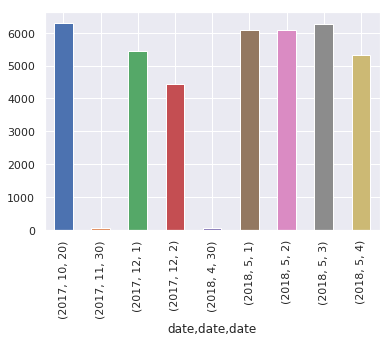

In [19]:
import pandas as pd
import datetime

try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)
    
cur_read = conn.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT start_ep, flight_id \
                 FROM public.adsb_flights;")

batch = cur_read.fetchall()

x = [b['start_ep'] for b in batch] 

daylst = list(set([datetime.datetime.fromtimestamp(xx).strftime('%Y-%m-%d %H') for xx in x]))
eplist = [(datetime.datetime.strptime(ts,'%Y-%m-%d %H') - datetime.datetime(1970, 1, 1)).total_seconds() for ts in daylst]

df = pd.DataFrame()
df['epoch'] = x
df['date'] = [datetime.datetime.fromtimestamp(d) for d in df['epoch']]
df['date'].groupby([df["date"].dt.year, df["date"].dt.month, df["date"].dt.day]).count().plot(kind="bar")

In [35]:
'%s_1' % 'bla'

'bla_1'

In [14]:
len(list(set(daylst)))

170

In [15]:
len(daylst)

40040

In [20]:
eplist

[1525370400.0,
 1525298400.0,
 1512198000.0,
 1525273200.0,
 1525179600.0,
 1525442400.0,
 1525190400.0,
 1512126000.0,
 1508457600.0,
 1512172800.0,
 1525302000.0,
 1512219600.0,
 1525147200.0,
 1525183200.0,
 1525327200.0,
 1525316400.0,
 1525435200.0,
 1512205200.0,
 1512122400.0,
 1508461200.0,
 1512255600.0,
 1512165600.0,
 1512133200.0,
 1525388400.0,
 1512248400.0,
 1525323600.0,
 1512176400.0,
 1525237200.0,
 1512252000.0,
 1525291200.0,
 1525266000.0,
 1525240800.0,
 1512104400.0,
 1525352400.0,
 1525413600.0,
 1508472000.0,
 1525201200.0,
 1512086400.0,
 1525356000.0,
 1508522400.0,
 1512244800.0,
 1525366800.0,
 1512234000.0,
 1525438800.0,
 1525251600.0,
 1512151200.0,
 1525374000.0,
 1512194400.0,
 1508464800.0,
 1512158400.0,
 1525150800.0,
 1525309200.0,
 1508511600.0,
 1525194000.0,
 1525406400.0,
 1508500800.0,
 1512169200.0,
 1525363200.0,
 1525161600.0,
 1512108000.0,
 1525136400.0,
 1525359600.0,
 1512187200.0,
 1525431600.0,
 1525226400.0,
 1512208800.0,
 152533440